In [64]:
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score, train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline


ĐỀ TÀI:
1.	DỰ ĐOÁN SỐ BÀN THẮNG CỦA MỘT TRẬN ĐẤU DỰA TRÊN CÁC THÔNG TIN CÓ SẴN (CÓ TEST THỬ KHI TRẬN ĐẤU ĐÃ DIỄN RA)
2.	lưu ý
3.	mô hình không dự đoán chính xác 100%, vì:
    o	yếu tố con người:phong độ, trọng tài, tâm lý, bùng nổ của các cá nhân,... là những thứ máy học khó lường trước được cho nên có thể những trận trước đội A đã dỡ nhưng trận này thì lại bùng nổ. trận đấu càng có nhiều biến cố thì càng khó dự đoán chính xác
    o	EPL hay championship là 2 giải đầu khá là tương đồng về tính cạnh tranh, có thể nói là cạnh tranh nhất 5 giải đấu hàng đầu và là epl là giải hấp dẫn nhất châu âu.
    o	EPL pressing cao, đa dạng , còn championship tuy ít pressing và hay bóng dài nhưng có vài đội xuống và lên 2 hạng cũng mang đặc trưng từ epl xuống dù là xuống hạng nhưng ở championship họ vẫn mạnh
4.	vì vậy, những trận có nhiều bàn thắng khá ít xảy ra vì nó cạnh tranh rất cao đội mạnh có thể bất ngờ thua hay trong tích tắc có thể bị ghi bàn nếu không xử lý nhanh. có thể mô hình này chưa tối ưu nhất theo cá nhân của mỗi người.



1/  import thư viện
2/  đọc file, gộp file,xóa dòng thiếu dữ liệu(giải thích sau)
3/  merge file
4/  xử lý dữ liệu trong file
5/  chia tập train và test
6/  chạy thử mô hình, kiểm tra overfitting và underfitting xuyên suốt giai đoạn train(cross validation)
7/  thử với dữ liệu thực tế của trận đã diễn ra (với 1-2 mô hình)
8/  chạy 5 mô hình,trực quan
9/  tối ưu hóa bằng gridcv cùng 5 mô hình, trực quan
10/ đánh giá mô hình,kết luận mô hình tối ưu
11/ dùng trung bình có trọng số để tính toán bám sát kết quả kết hợp 5 mô hình,trực quan
12/ kết luận tổng thể dự án,đánh giá tính khả thi

5 mô hình sẽ áp dụng
1. Poisson Regression (Poisson):
Lý do chọn: Mô hình Poisson là một mô hình thống kê rất phổ biến trong các bài toán liên quan đến sự kiện xảy ra theo kiểu đếm (count data). Trong bóng đá, số bàn thắng có thể được coi là dữ liệu đếm, và Poisson regression thường được sử dụng trong các nghiên cứu dự đoán số lượng bàn thắng trong một trận đấu.

Ưu điểm: Mô hình này đơn giản, dễ hiểu và có thể đưa ra các kết quả có tính lý thuyết cao khi số lượng bàn thắng là một sự kiện hiếm gặp. Poisson cũng đặc biệt hữu ích khi dữ liệu có tính phân phối Poisson.

Hạn chế: Mô hình này có thể không hiệu quả khi dữ liệu có quá nhiều sự biến động hoặc quá phức tạp.

2. Random Forest (RF):
Lý do chọn: Random Forest là một mô hình học máy mạnh mẽ dựa trên cây quyết định. Nó hoạt động tốt với các tập dữ liệu phức tạp và có thể tự động xử lý các mối quan hệ phi tuyến tính trong dữ liệu.

Ưu điểm: Mô hình Random Forest có khả năng xử lý tốt với dữ liệu không đồng nhất và có thể tránh được overfitting nhờ vào việc tạo ra nhiều cây quyết định trên các mẫu ngẫu nhiên.

Hạn chế: Mặc dù Random Forest có thể cho kết quả tốt trong nhiều bài toán, nhưng nó có thể gặp khó khăn trong việc xử lý các mối quan hệ phức tạp mà không phải là cây quyết định rõ ràng.

3. XGBoost:
Lý do chọn: XGBoost (Extreme Gradient Boosting) là một trong những mô hình học máy phổ biến và mạnh mẽ nhất, đặc biệt là trong các cuộc thi về dữ liệu. XGBoost là một thuật toán boosting cho phép tối ưu hóa hiệu suất dự đoán với dữ liệu phức tạp.

Ưu điểm: XGBoost có thể xử lý các vấn đề không đồng đều, có thể cải thiện độ chính xác của mô hình nhờ vào việc chọn lựa các đặc trưng tốt hơn. Mô hình này rất mạnh khi dữ liệu có nhiều mối quan hệ phi tuyến tính.

Hạn chế: Việc huấn luyện mô hình XGBoost có thể tốn thời gian và yêu cầu tối ưu hóa tham số cẩn thận.

4. LightGBM:
Lý do chọn: LightGBM (Light Gradient Boosting Machine) là một mô hình học máy mạnh mẽ và nhanh chóng, được thiết kế để xử lý dữ liệu lớn và phức tạp. Đây là một phiên bản tối ưu hóa của XGBoost.

Ưu điểm: LightGBM rất hiệu quả về mặt tốc độ và có thể xử lý được các tập dữ liệu cực kỳ lớn. Nó sử dụng thuật toán histogram-based learning để phân chia dữ liệu, giúp giảm thời gian tính toán.

Hạn chế: LightGBM có thể yêu cầu nhiều bộ nhớ hơn khi xử lý với các bộ dữ liệu quá lớn.

5. Gradient Boosting:
Lý do chọn: Gradient Boosting là một thuật toán học máy mạnh mẽ trong việc xây dựng mô hình bằng cách kết hợp nhiều cây quyết định (hoặc mô hình học máy khác) để tối ưu hóa dự đoán.

Ưu điểm: Gradient Boosting có thể tối ưu hóa cho bất kỳ loại bài toán nào, đặc biệt là trong các bài toán hồi quy và phân loại. Mô hình này dễ dàng tinh chỉnh để cải thiện hiệu suất.

Hạn chế: Giống như XGBoost, Gradient Boosting có thể gặp khó khăn khi xử lý dữ liệu quá lớn và cần tối ưu tham số rất tỉ mỉ.

các hàm sử dụng:
✅ MAE – Mean Absolute Error (Sai số tuyệt đối trung bình)
Ý nghĩa: Là trung bình của các giá trị tuyệt đối của sai số giữa giá trị dự đoán và giá trị thực tế.
Lý do sử dụng:
Rất dễ hiểu và trực quan: "Dự đoán của mô hình sai trung bình bao nhiêu đơn vị?"
Ít bị ảnh hưởng bởi outlier (giá trị ngoại lai) hơn MSE/RMSE.

📌 print(f"Mean Squared Error (MSE): {mse:.2f}")
✅ MSE – Mean Squared Error (Sai số bình phương trung bình)
Ý nghĩa: Trung bình của bình phương các sai số giữa giá trị thực tế và dự đoán.
Lý do sử dụng:
Nhấn mạnh vào các sai số lớn (do bình phương): tốt để phát hiện mô hình nào có dự đoán rất lệch.
Phổ biến trong huấn luyện mô hình vì có đạo hàm mượt, dễ tối ưu.

📌 print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
✅ RMSE – Root Mean Squared Error (Căn bậc hai của MSE)
Ý nghĩa: Giống MSE, nhưng đưa kết quả về cùng đơn vị với đầu ra gốc.
Lý do sử dụng:
Dễ hiểu hơn MSE vì đơn vị của nó giống với đơn vị của biến cần dự đoán.
Cũng nhạy cảm với outliers, nhưng dễ đọc hơn.

📌  print(f"R² Score: {r2:.2f}")
✅ R² Score (Hệ số xác định – Coefficient of Determination)
Ý nghĩa: Cho biết mô hình giải thích được bao nhiêu phần trăm phương sai của dữ liệu đầu ra.
Lý do sử dụng:
R² nằm trong khoảng từ âm vô cùng đến 1:
1: mô hình hoàn hảo
0: mô hình tệ như việc đoán trung bình
< 0: mô hình còn tệ hơn việc đoán trung bình
Được dùng rộng rãi để đánh giá độ phù hợp tổng thể của mô hình.

    cross_val_score là một hàm trong Scikit-learn dùng để thực hiện k-fold cross-validation cho một mô hình học máy. Nó đánh giá mô hình trên nhiều tập con khác nhau của dữ liệu và trả về các điểm số, giúp bạn đánh giá khả năng tổng quát của mô hình.
Ý nghĩa của cross_val_score
    cross_val_score giúp đánh giá độ chính xác của mô hình qua việc chạy k-fold cross-validation, tức là chia dữ liệu thành k phần (folds), mỗi phần sẽ được dùng làm tập kiểm tra một lần, trong khi các phần còn lại được dùng để huấn luyện mô hình.
Lý do chọn cross_val_score
Khả năng tổng quát cao hơn: Khi sử dụng cross-validation, bạn không chỉ dựa vào một phân chia cố định của dữ liệu mà thay vào đó mô hình được đánh giá trên nhiều phân chia khác nhau. Điều này giúp bạn có một cái nhìn công bằng và chính xác hơn về hiệu suất của mô hình.
Chắc chắn hơn về độ ổn định của mô hình: Nếu mô hình cho kết quả tương đối ổn định qua tất cả các fold, bạn có thể tin tưởng vào khả năng tổng quát của mô hình. Nếu kết quả dao động lớn, mô hình có thể cần cải tiến.


đọc file csv vào

In [3]:
file_path = 'England CSV.csv' #đọc dữ liệu
df = pd.read_csv(file_path) #đọc dữ liệu
print(df.shape)


(9329, 25)


xem đuôi

In [4]:
df.tail()

,Date,Season,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,...,H Fouls,A Fouls,H Corners,A Corners,H Yellow,A Yellow,H Red,A Red,Display_Order,League
9324,19/08/2000,2000/01,Leicester,Aston Villa,0,0,D,0.0,0.0,D,...,12.0,12.0,5.0,4.0,2.0,3.0,0.0,0.0,20000819,Premier League
9325,19/08/2000,2000/01,Leeds,Everton,2,0,H,2.0,0.0,H,...,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0,20000819,Premier League
9326,19/08/2000,2000/01,Derby,Southampton,2,2,D,1.0,2.0,A,...,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0,20000819,Premier League
9327,19/08/2000,2000/01,Coventry,Middlesbrough,1,3,A,1.0,1.0,D,...,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0,20000819,Premier League
9328,19/08/2000,2000/01,Chelsea,West Ham,4,2,H,1.0,0.0,H,...,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0,20000819,Premier League


có nhiều ô Nan từ 1992 tới 2000 
có thể thay thế bằng giá trị trung bình nhưng điều này sẽ làm giả giá trị từ đó sẽ ít bám sát thực tế.
lựa chọn tối ưu: xóa luôn (epl còn champion ship thì đủ từ ô cuối cùng) epl từ 00/01 mới có
epl: từ 1993/1994
champion ship 2004/2005

In [5]:
# In DataFrame ban đầu để thấy sự khác biệt
print("DataFrame ban đầu:")
print(df)
print("-" * 30)

# Bước 1: Xác định các record cần xóa (displayorder bé hơn 20000819)
threshold = 20000819
mask = df['Display_Order'] < threshold

# Bước 2: Xóa các record này khỏi DataFrame
df_filtered = df[~mask]

# Hoặc, nếu bạn muốn xóa trực tiếp trên DataFrame hiện tại (inplace):
# df.drop(df[mask].index, inplace=True)

# In DataFrame sau khi đã xóa
print(f"DataFrame sau khi xóa các record có displayorder bé hơn {threshold}:")
print(df_filtered)

DataFrame ban đầu:
            Date   Season      HomeTeam                AwayTeam  FTH Goals  \
0     16/01/2025  2024/25  Ipswich Town  Brighton & Hove Albion          0   
1     16/01/2025  2024/25    Man United             Southampton          3   
2     15/01/2025  2024/25       Everton             Aston Villa          0   
3     15/01/2025  2024/25     Leicester          Crystal Palace          0   
4     15/01/2025  2024/25     Newcastle                  Wolves          3   
...          ...      ...           ...                     ...        ...   
9324  19/08/2000  2000/01     Leicester             Aston Villa          0   
9325  19/08/2000  2000/01         Leeds                 Everton          2   
9326  19/08/2000  2000/01         Derby             Southampton          2   
9327  19/08/2000  2000/01      Coventry           Middlesbrough          1   
9328  19/08/2000  2000/01       Chelsea                West Ham          4   

      FTA Goals FT Result  HTH Goals  HTA Go

In [6]:
# Giả sử DataFrame sau khi đã xóa là df_filtered

# Chỉ định đường dẫn đến file CSV bạn muốn ghi đè
file_path = 'England CSV.csv'  # Thay 'your_file.csv' bằng đường dẫn thực tế đến file của bạn

# Ghi DataFrame đã lọc vào file CSV, ghi đè lên file cũ
df_filtered.to_csv(file_path, index=False, encoding='utf-8')

print(f"DataFrame đã được ghi đè lên file CSV: {file_path}")

DataFrame đã được ghi đè lên file CSV: England CSV.csv


check lại file epl đã cập nhật chưa

In [7]:
df.tail()

,Date,Season,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,...,H Fouls,A Fouls,H Corners,A Corners,H Yellow,A Yellow,H Red,A Red,Display_Order,League
9324,19/08/2000,2000/01,Leicester,Aston Villa,0,0,D,0.0,0.0,D,...,12.0,12.0,5.0,4.0,2.0,3.0,0.0,0.0,20000819,Premier League
9325,19/08/2000,2000/01,Leeds,Everton,2,0,H,2.0,0.0,H,...,21.0,20.0,6.0,4.0,1.0,3.0,0.0,0.0,20000819,Premier League
9326,19/08/2000,2000/01,Derby,Southampton,2,2,D,1.0,2.0,A,...,11.0,13.0,5.0,8.0,1.0,1.0,0.0,0.0,20000819,Premier League
9327,19/08/2000,2000/01,Coventry,Middlesbrough,1,3,A,1.0,1.0,D,...,15.0,21.0,8.0,4.0,5.0,3.0,1.0,0.0,20000819,Premier League
9328,19/08/2000,2000/01,Chelsea,West Ham,4,2,H,1.0,0.0,H,...,19.0,14.0,7.0,7.0,1.0,2.0,0.0,0.0,20000819,Premier League


đọc file championship

In [8]:
df2 = pd.read_csv('England 2 CSV.csv') #đọc dữ liệu
print(df2.shape)


(11351, 25)


gộp file lại

In [9]:
df_merged = pd.concat([df, df2], ignore_index=True)
df_merged.to_csv('df_merged.csv', index=False)

gộp 2 file lại
nhận xét: cả 2 file đều chung tên cột và đã xử lý kiểu dữ liệu nên dễ dàng gộp

kiểm tra dữ liệu file mới

In [10]:
df3 = pd.read_csv('df_merged.csv')
print(df3.shape)

(20680, 25)


In [11]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20680 entries, 0 to 20679
Data columns (total 25 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           20680 non-null  object 
 1   Season         20680 non-null  object 
 2   HomeTeam       20680 non-null  object 
 3   AwayTeam       20680 non-null  object 
 4   FTH Goals      20680 non-null  int64  
 5   FTA Goals      20680 non-null  int64  
 6   FT Result      20680 non-null  object 
 7   HTH Goals      20679 non-null  float64
 8   HTA Goals      20679 non-null  float64
 9   HT Result      20679 non-null  object 
 10  Referee        20127 non-null  object 
 11  H Shots        20679 non-null  float64
 12  A Shots        20679 non-null  float64
 13  H SOT          20679 non-null  float64
 14  A SOT          20679 non-null  float64
 15  H Fouls        20679 non-null  float64
 16  A Fouls        20679 non-null  float64
 17  H Corners      20679 non-null  float64
 18  A Corn

giải thích các cột
Date: Ngày diễn ra trận đấu.
Season: Mùa giải mà trận đấu thuộc về (ví dụ: 2023/2024).
HomeTeam: Tên đội chủ nhà (đội chơi trên sân nhà).
AwayTeam: Tên đội khách (đội chơi trên sân đối phương).
FTH Goals: Số bàn thắng của đội chủ nhà trong toàn trận (Full-Time Home Goals).
FTA Goals: Số bàn thắng của đội khách trong toàn trận (Full-Time Away Goals).
FT Result: Kết quả toàn trận (Full-Time Result), thường là "H" (chủ nhà thắng), "A" (khách thắng), hoặc "D" (hòa).
HTH Goals: Số bàn thắng của đội chủ nhà trong hiệp 1 (Half-Time Home Goals).
HTA Goals: Số bàn thắng của đội khách trong hiệp 1 (Half-Time Away Goals).
HT Result: Kết quả hiệp 1 (Half-Time Result), tương tự FT Result: "H", "A", hoặc "D".
Referee: Tên trọng tài điều khiển trận đấu.
H Shots: Số cú sút của đội chủ nhà (Home Shots).
A Shots: Số cú sút của đội khách (Away Shots).
H SOT: Số cú sút trúng khung thành của đội chủ nhà (Home Shots on Target).
A SOT: Số cú sút trúng khung thành của đội khách (Away Shots on Target).
H Fouls: Số lần phạm lỗi của đội chủ nhà (Home Fouls).
A Fouls: Số lần phạm lỗi của đội khách (Away Fouls).
H Corners: Số quả phạt góc của đội chủ nhà (Home Corners).
A Corners: Số quả phạt góc của đội khách (Away Corners).
H Yellow: Số thẻ vàng của đội chủ nhà (Home Yellow Cards).
A Yellow: Số thẻ vàng của đội khách (Away Yellow Cards).
H Red: Số thẻ đỏ của đội chủ nhà (Home Red Cards).
A Red: Số thẻ đỏ của đội khách (Away Red Cards).
Display_Order: Thứ tự hiển thị của trận đấu, có thể liên quan đến cách sắp xếp dữ liệu (ví dụ: theo thời gian hoặc tầm quan trọng).
League: Giải đấu mà trận đấu thuộc về (ví dụ: Premier League, La Liga, v.v.).

In [12]:
print(df3.dtypes)

Date              object
Season            object
HomeTeam          object
AwayTeam          object
FTH Goals          int64
FTA Goals          int64
FT Result         object
HTH Goals        float64
HTA Goals        float64
HT Result         object
Referee           object
H Shots          float64
A Shots          float64
H SOT            float64
A SOT            float64
H Fouls          float64
A Fouls          float64
H Corners        float64
A Corners        float64
H Yellow         float64
A Yellow         float64
H Red            float64
A Red            float64
Display_Order      int64
League            object
dtype: object


nhận xét: có nhiều cột cần được chuyển đổi kiểu dữ liệu sang kiểu hợp lý.
ví dụ HTH,HTA goals: bàn thắng không có thập phân -> đổi
 Date (object → datetime64):
Lý do: Cột ngày tháng nên được chuyển thành kiểu datetime64 để dễ dàng xử lý các phép tính thời gian (ví dụ: lọc theo ngày, tính khoảng cách thời gian).
Cách thực hiện: pd.to_datetime(df['Date']).
Season (object → string hoặc giữ object):
Lý do: Cột này thường chứa chuỗi như "2023/2024". Kiểu string (hoặc category nếu số lượng mùa giải ít) là phù hợp. Giữ object cũng ổn nếu không cần tối ưu hóa.
Đề xuất: Chuyển thành string hoặc category nếu muốn tiết kiệm bộ nhớ.
HomeTeam, AwayTeam (object → string hoặc category):
Lý do: Tên đội bóng là chuỗi. Nếu số lượng đội bóng giới hạn (ví dụ: 20 đội trong một giải), category sẽ tiết kiệm bộ nhớ và tăng hiệu suất.
Đề xuất: Chuyển thành category.
FTH Goals, FTA Goals (int64 → giữ int64):
Lý do: Số bàn thắng toàn trận là số nguyên, int64 đã phù hợp.
Đề xuất: Giữ nguyên.
FT Result (object → category):
Lý do: Kết quả trận đấu chỉ có 3 giá trị ("H", "A", "D"). Kiểu category phù hợp hơn object vì tiết kiệm bộ nhớ và tăng hiệu suất.
Đề xuất: Chuyển thành category.
HTH Goals, HTA Goals (float64 → int64):
Lý do: Số bàn thắng hiệp 1 là số nguyên (không có bàn thắng thập phân). float64 không cần thiết trừ khi dữ liệu có giá trị NaN (thiếu dữ liệu). Nếu có NaN, có thể dùng Int64 (nullable integer).
Đề xuất: Chuyển thành int64 hoặc Int64 nếu có NaN.
HT Result (object → category):
Lý do: Tương tự FT Result, chỉ có 3 giá trị ("H", "A", "D").
Đề xuất: Chuyển thành category.
Referee (object → string hoặc category):
Lý do: Tên trọng tài là chuỗi. Nếu số lượng trọng tài giới hạn, category sẽ hiệu quả hơn.
Đề xuất: Chuyển thành category.
H Shots, A Shots, H SOT, A SOT, H Fouls, A Fouls, H Corners, A Corners, H Yellow, A Yellow, H Red, A Red (float64 → int64 hoặc Int64):
Lý do: Các thống kê như số cú sút, phạm lỗi, phạt góc, thẻ phạt là số nguyên (không có giá trị thập phân). float64 chỉ cần thiết nếu có NaN. Nếu không có NaN, chuyển thành int64. Nếu có NaN, dùng Int64.
Đề xuất: Chuyển thành int64 hoặc Int64.
Display_Order (int64 → giữ int64):
Lý do: Thứ tự hiển thị là số nguyên, int64 đã phù hợp.
Đề xuất: Giữ nguyên.
League (object → string hoặc category):
Lý do: Tên giải đấu là chuỗi. Nếu số lượng giải đấu ít, category sẽ tiết kiệm bộ nhớ.
Đề xuất: Chuyển thành category.

In [13]:

# Giả sử df là DataFrame chứa dữ liệu
# Chuyển đổi kiểu dữ liệu
df3['Date'] = pd.to_datetime(df3['Date'])
df3['Season'] = df3['Season'].astype('string')
df3['HomeTeam'] = df3['HomeTeam'].astype('category')
df3['AwayTeam'] = df3['AwayTeam'].astype('category')
df3['FT Result'] = df3['FT Result'].astype('category')
df3['HT Result'] = df3['HT Result'].astype('category')
df3['Referee'] = df3['Referee'].astype('category')
df3['League'] = df3['League'].astype('category')

# Chuyển các cột float64 thành int64 (hoặc Int64 nếu có NaN)
int_columns = ['HTH Goals', 'HTA Goals', 'H Shots', 'A Shots', 'H SOT', 'A SOT',
               'H Fouls', 'A Fouls', 'H Corners', 'A Corners', 'H Yellow', 'A Yellow', 'H Red', 'A Red']
for col in int_columns:
    df3[col] = df3[col].astype('Int64')  # Dùng Int64 để xử lý NaN, hoặc 'int64' nếu chắc chắn không có NaN

# Kiểm tra lại kiểu dữ liệu
print(df3.dtypes)

Date             datetime64[ns]
Season           string[python]
HomeTeam               category
AwayTeam               category
FTH Goals                 int64
FTA Goals                 int64
FT Result              category
HTH Goals                 Int64
HTA Goals                 Int64
HT Result              category
Referee                category
H Shots                   Int64
A Shots                   Int64
H SOT                     Int64
A SOT                     Int64
H Fouls                   Int64
A Fouls                   Int64
H Corners                 Int64
A Corners                 Int64
H Yellow                  Int64
A Yellow                  Int64
H Red                     Int64
A Red                     Int64
Display_Order             int64
League                 category
dtype: object


kiểm tra null và Nan

In [14]:
df3.isnull().sum()

Date               0
Season             0
HomeTeam           0
AwayTeam           0
FTH Goals          0
FTA Goals          0
FT Result          0
HTH Goals          1
HTA Goals          1
HT Result          1
Referee          553
H Shots            1
A Shots            1
H SOT              1
A SOT              1
H Fouls            1
A Fouls            1
H Corners          1
A Corners          1
H Yellow           1
A Yellow           1
H Red              1
A Red              1
Display_Order      0
League             0
dtype: int64

In [15]:
df3.isna().sum()

Date               0
Season             0
HomeTeam           0
AwayTeam           0
FTH Goals          0
FTA Goals          0
FT Result          0
HTH Goals          1
HTA Goals          1
HT Result          1
Referee          553
H Shots            1
A Shots            1
H SOT              1
A SOT              1
H Fouls            1
A Fouls            1
H Corners          1
A Corners          1
H Yellow           1
A Yellow           1
H Red              1
A Red              1
Display_Order      0
League             0
dtype: int64

Giải thích cách tính từng cột
Dựa trên các công thức bạn đã cung cấp trước đó, đây là cách tính từng cột đặc trưng:

H_Goal_Conversion: Tỷ lệ chuyển hóa cơ hội đội chủ nhà.
Công thức: FTHG / HST nếu HST > 0, ngược lại 0.
Ý nghĩa: Đo lường hiệu quả ghi bàn từ các cú sút trúng đích của đội chủ nhà.
Dữ liệu cần: FTHG (bàn thắng đội chủ nhà), HST (sút trúng đích đội chủ nhà).
A_Goal_Conversion: Tỷ lệ chuyển hóa cơ hội đội khách.
Công thức: FTAG / AST nếu AST > 0, ngược lại 0.
Ý nghĩa: Đo lường hiệu quả ghi bàn từ các cú sút trúng đích của đội khách.
Dữ liệu cần: FTAG (bàn thắng đội khách), AST (sút trúng đích đội khách).
Expected_Goals_Home: Dự đoán bàn thắng kỳ vọng đội chủ nhà.
Công thức: 0.3 * HST + 0.1 * HC.
Ý nghĩa: Ước lượng số bàn thắng kỳ vọng dựa trên số cú sút trúng đích và phạt góc của đội chủ nhà.
Dữ liệu cần: HST (sút trúng đích đội chủ nhà), HC (phạt góc đội chủ nhà).
Expected_Goals_Away: Dự đoán bàn thắng kỳ vọng đội khách.
Công thức: 0.3 * AST + 0.1 * AC.
Ý nghĩa: Ước lượng số bàn thắng kỳ vọng dựa trên số cú sút trúng đích và phạt góc của đội khách.
Dữ liệu cần: AST (sút trúng đích đội khách), AC (phạt góc đội khách).
H_Shot_Efficiency: Hiệu quả sút bóng đội chủ nhà.
Công thức: HST / HS nếu HS > 0, ngược lại 0.
Ý nghĩa: Đo lường tỷ lệ cú sút trúng đích trên tổng số cú sút của đội chủ nhà.
Dữ liệu cần: HST (sút trúng đích đội chủ nhà), HS (sút bóng đội chủ nhà).
A_Shot_Efficiency: Hiệu quả sút bóng đội khách.
Công thức: AST / AS nếu AS > 0, ngược lại 0.
Ý nghĩa: Đo lường tỷ lệ cú sút trúng đích trên tổng số cú sút của đội khách.
Dữ liệu cần: AST (sút trúng đích đội khách), AS (sút bóng đội khách).
Match_Intensity: Cường độ tổng thể của trận đấu.
Công thức: H_Attack_Intensity + A_Attack_Intensity.
Ý nghĩa: Tổng hợp cường độ tấn công của cả hai đội, phản ánh mức độ sôi nổi của trận đấu.
Dữ liệu cần: H_Attack_Intensity và A_Attack_Intensity (tính ở bước sau).
H_Avg_Corners_Last5: Trung bình phạt góc của đội chủ nhà trong 5 trận gần nhất.
Công thức: Trung bình của HC trong 5 trận trước của đội chủ nhà (dựa trên HomeTeam).
Ý nghĩa: Phản ánh xu hướng tạo phạt góc của đội chủ nhà trong các trận gần đây.
Dữ liệu cần: HC (phạt góc đội chủ nhà), HomeTeam (định danh đội chủ nhà).
A_Avg_Goals_Last5: Trung bình bàn thắng của đội khách trong 5 trận gần nhất.
Công thức: Trung bình của FTAG trong 5 trận trước của đội khách (dựa trên AwayTeam).
Ý nghĩa: Phản ánh phong độ ghi bàn của đội khách trong các trận gần đây.
Dữ liệu cần: FTAG (bàn thắng đội khách), AwayTeam (định danh đội khách).
H_Avg_Goals_Last5: Trung bình bàn thắng của đội chủ nhà trong 5 trận gần nhất.
Công thức: Trung bình của FTHG trong 5 trận trước của đội chủ nhà (dựa trên HomeTeam).
Ý nghĩa: Phản ánh phong độ ghi bàn của đội chủ nhà trong các trận gần đây.
Dữ liệu cần: FTHG (bàn thắng đội chủ nhà), HomeTeam (định danh đội chủ nhà).
A_Avg_Corners_Last5: Trung bình phạt góc của đội khách trong 5 trận gần nhất.
Công thức: Trung bình của AC trong 5 trận trước của đội khách (dựa trên AwayTeam).
Ý nghĩa: Phản ánh xu hướng tạo phạt góc của đội khách trong các trận gần đây.
Dữ liệu cần: AC (phạt góc đội khách), AwayTeam (định danh đội khách).
A_Attack_Intensity: Cường độ tấn công đội khách.
Công thức: AS + AST + AC.
Ý nghĩa: Tổng hợp các chỉ số tấn công (sút bóng, sút trúng đích, phạt góc) của đội khách.
Dữ liệu cần: AS (sút bóng đội khách), AST (sút trúng đích đội khách), AC (phạt góc đội khách).
H_Attack_Intensity: Cường độ tấn công đội chủ nhà.
Công thức: HS + HST + HC.
Ý nghĩa: Tổng hợp các chỉ số tấn công (sút bóng, sút trúng đích, phạt góc) của đội chủ nhà.
Dữ liệu cần: HS (sút bóng đội chủ nhà), HST (sút trúng đích đội chủ nhà), HC (phạt góc đội chủ nhà).
cùng với việc thêm cột, ta xử lý null và nan luôn
vì tổng null/nan không quá lớn nên có thể thay bằng 0
những cột ngày là kết quả của việc thêm cột và xóa cột nhiều lần để cho ra những cột mà tôi cho là quan trọng nhất

In [16]:


# Kiểm tra các hàng có NaN/null để xác định nếu chúng nằm trong cùng một hàng
columns_to_check = ['FTH Goals', 'FTA Goals', 'H SOT', 'A SOT', 'H Shots', 'A Shots', 
                    'H Corners', 'A Corners']
nan_rows = df3[columns_to_check].isna().any(axis=1)
print("Các hàng có NaN/null trong các cột đầu vào:\n", df3[nan_rows][columns_to_check])

# Xử lý NaN/null
# Thay NaN/null bằng 0 cho các cột số nguyên hoặc số thực
numeric_columns = ['FTH Goals', 'FTA Goals', 'H SOT', 'A SOT', 'H Shots', 'A Shots', 
                   'H Corners', 'A Corners']
for col in numeric_columns:
    df3[col] = df3[col].fillna(0)

# Kiểm tra lại số lượng NaN/null trong các cột đầu vào
print("\nSố lượng NaN sau xử lý trong các cột đầu vào:\n", df3[numeric_columns].isna().sum())

# Đảm bảo cột Date ở định dạng datetime và sắp xếp theo thời gian
df3['Date'] = pd.to_datetime(df3['Date'])
df3 = df3.sort_values(by=['Date', 'HomeTeam', 'AwayTeam'])

# Tính toán các cột đặc trưng
# 1. H_Goal_Conversion
df3['H_Goal_Conversion'] = np.where(df3['H SOT'] > 0, df3['FTH Goals'] / df3['H SOT'], 0)

# 2. A_Goal_Conversion
df3['A_Goal_Conversion'] = np.where(df3['A SOT'] > 0, df3['FTA Goals'] / df3['A SOT'], 0)

# 3. Expected_Goals_Home
df3['Expected_Goals_Home'] = 0.3 * df3['H SOT'] + 0.1 * df3['H Corners']

# 4. Expected_Goals_Away
df3['Expected_Goals_Away'] = 0.3 * df3['A SOT'] + 0.1 * df3['A Corners']

# 5. H_Shot_Efficiency
df3['H_Shot_Efficiency'] = np.where(df3['H Shots'] > 0, df3['H SOT'] / df3['H Shots'], 0)

# 6. A_Shot_Efficiency
df3['A_Shot_Efficiency'] = np.where(df3['A Shots'] > 0, df3['A SOT'] / df3['A Shots'], 0)

# 7. H_Attack_Intensity
df3['H_Attack_Intensity'] = df3['H Shots'] + df3['H SOT'] + df3['H Corners']

# 8. A_Attack_Intensity
df3['A_Attack_Intensity'] = df3['A Shots'] + df3['A SOT'] + df3['A Corners']

# 9. Match_Intensity
df3['Match_Intensity'] = df3['H_Attack_Intensity'] + df3['A_Attack_Intensity']

# 10. H_Avg_Goals_Last5
df3['H_Avg_Goals_Last5'] = df3.groupby('HomeTeam')['FTH Goals'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# 11. A_Avg_Goals_Last5
df3['A_Avg_Goals_Last5'] = df3.groupby('AwayTeam')['FTA Goals'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# 12. H_Avg_Corners_Last5
df3['H_Avg_Corners_Last5'] = df3.groupby('HomeTeam')['H Corners'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)

# 13. A_Avg_Corners_Last5
df3['A_Avg_Corners_Last5'] = df3.groupby('AwayTeam')['A Corners'].transform(
    lambda x: x.shift(1).rolling(window=5, min_periods=1).mean()
)
# Calculate Total_Goals as the sum of FTH Goals and FTA Goals
df3['Total_Goals'] = df3['FTH Goals'] + df3['FTA Goals']
# Kiểm tra NaN trong các cột vừa tính
calculated_columns = [
    'H_Goal_Conversion', 'A_Goal_Conversion', 'Expected_Goals_Home', 'Expected_Goals_Away',
    'H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Attack_Intensity', 'A_Attack_Intensity',
    'Match_Intensity', 'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'H_Avg_Corners_Last5',
    'A_Avg_Corners_Last5'
]
print("\nSố lượng NaN trong các cột đã tính:\n", df3[calculated_columns].isna().sum())

# Thay NaN bằng 0 trong các cột vừa tính (nếu có)
for col in calculated_columns:
    df3[col] = df3[col].fillna(0)

# Kiểm tra lại lần cuối
print("\nSố lượng NaN sau khi xử lý lần cuối:\n", df3[calculated_columns].isna().sum())

# Xem kết quả
print("\nKết quả 5 dòng đầu tiên:\n", df3[[
    'Date', 'HomeTeam', 'AwayTeam', 'H_Goal_Conversion', 'A_Goal_Conversion', 
    'Expected_Goals_Home', 'Expected_Goals_Away', 'H_Shot_Efficiency', 
    'A_Shot_Efficiency', 'Match_Intensity', 'H_Avg_Corners_Last5', 
    'A_Avg_Goals_Last5', 'H_Avg_Goals_Last5', 'A_Avg_Corners_Last5', 
    'A_Attack_Intensity', 'H_Attack_Intensity'
]].head())

Các hàng có NaN/null trong các cột đầu vào:
        FTH Goals  FTA Goals  H SOT  A SOT  H Shots  A Shots  H Corners  \
12416          0          1   <NA>   <NA>     <NA>     <NA>       <NA>   

       A Corners  
12416       <NA>  

Số lượng NaN sau xử lý trong các cột đầu vào:
 FTH Goals    0
FTA Goals    0
H SOT        0
A SOT        0
H Shots      0
A Shots      0
H Corners    0
A Corners    0
dtype: int64

Số lượng NaN trong các cột đã tính:
 H_Goal_Conversion       0
A_Goal_Conversion       0
Expected_Goals_Home     0
Expected_Goals_Away     0
H_Shot_Efficiency       0
A_Shot_Efficiency       0
H_Attack_Intensity      0
A_Attack_Intensity      0
Match_Intensity         0
H_Avg_Goals_Last5      67
A_Avg_Goals_Last5      67
H_Avg_Corners_Last5    67
A_Avg_Corners_Last5    67
dtype: int64

Số lượng NaN sau khi xử lý lần cuối:
 H_Goal_Conversion      0
A_Goal_Conversion      0
Expected_Goals_Home    0
Expected_Goals_Away    0
H_Shot_Efficiency      0
A_Shot_Efficiency      0
H_Attack_

In [17]:
# Check the total number of NaN values in the dataset
total_nan = df3.isna().sum().sum()
print(f"Total NaN values in the dataset: {total_nan}")

# Alternatively, check NaN values column-wise
nan_per_column = df3.isna().sum()
print("\nNaN values per column:")
print(nan_per_column)

Total NaN values in the dataset: 562

NaN values per column:
Date                     0
Season                   0
HomeTeam                 0
AwayTeam                 0
FTH Goals                0
FTA Goals                0
FT Result                0
HTH Goals                1
HTA Goals                1
HT Result                1
Referee                553
H Shots                  0
A Shots                  0
H SOT                    0
A SOT                    0
H Fouls                  1
A Fouls                  1
H Corners                0
A Corners                0
H Yellow                 1
A Yellow                 1
H Red                    1
A Red                    1
Display_Order            0
League                   0
H_Goal_Conversion        0
A_Goal_Conversion        0
Expected_Goals_Home      0
Expected_Goals_Away      0
H_Shot_Efficiency        0
A_Shot_Efficiency        0
H_Attack_Intensity       0
A_Attack_Intensity       0
Match_Intensity          0
H_Avg_Goals_Last5    

In [18]:
# Check the total number of null values in the dataset
total_null = df3.isnull().sum().sum()
print(f"Total null values in the dataset: {total_null}")

# Alternatively, check null values column-wise
null_per_column = df3.isnull().sum()
print("\nNull values per column:")
print(null_per_column)

Total null values in the dataset: 562

Null values per column:
Date                     0
Season                   0
HomeTeam                 0
AwayTeam                 0
FTH Goals                0
FTA Goals                0
FT Result                0
HTH Goals                1
HTA Goals                1
HT Result                1
Referee                553
H Shots                  0
A Shots                  0
H SOT                    0
A SOT                    0
H Fouls                  1
A Fouls                  1
H Corners                0
A Corners                0
H Yellow                 1
A Yellow                 1
H Red                    1
A Red                    1
Display_Order            0
League                   0
H_Goal_Conversion        0
A_Goal_Conversion        0
Expected_Goals_Home      0
Expected_Goals_Away      0
H_Shot_Efficiency        0
A_Shot_Efficiency        0
H_Attack_Intensity       0
A_Attack_Intensity       0
Match_Intensity          0
H_Avg_Goals_Last5  

tuy có null và nan nhưng những cột này chúng ta không dùng tới nên xóa luôn cũng được

In [19]:
df3.shape

(20680, 39)

In [20]:
df3.tail()

,Date,Season,HomeTeam,AwayTeam,FTH Goals,FTA Goals,FT Result,HTH Goals,HTA Goals,HT Result,...,H_Shot_Efficiency,A_Shot_Efficiency,H_Attack_Intensity,A_Attack_Intensity,Match_Intensity,H_Avg_Goals_Last5,A_Avg_Goals_Last5,H_Avg_Corners_Last5,A_Avg_Corners_Last5,Total_Goals
2,2025-01-15,2024/25,Everton,Aston Villa,0,1,A,0,0,D,...,0.300000,0.272727,21,19,40,1.0,0.4,4.8,5.2,1
3,2025-01-15,2024/25,Leicester,Crystal Palace,0,2,A,0,0,D,...,0.190476,0.444444,29,16,45,1.2,1.6,4.0,4.2,2
4,2025-01-15,2024/25,Newcastle,Wolves,3,0,H,1,0,H,...,0.294118,0.538462,26,22,48,2.2,2.0,6.2,2.4,3
0,2025-01-16,2024/25,Ipswich Town,Brighton & Hove Albion,0,2,A,0,1,A,...,0.600000,0.454545,9,25,34,0.0,0.0,0.0,0.0,2
1,2025-01-16,2024/25,Man United,Southampton,3,1,H,0,1,A,...,0.391304,0.384615,36,22,58,1.8,0.4,4.6,5.6,4


xóa cột không cần thiết

In [21]:
# List of columns to keep
columns_to_keep = [
    'Total_Goals', 'H_Goal_Conversion', 'A_Goal_Conversion', 'Expected_Goals_Home', 
    'Expected_Goals_Away', 'H_Shot_Efficiency', 'A_Shot_Efficiency', 
    'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 
    'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'H_Avg_Corners_Last5', 
    'A_Avg_Corners_Last5'
]

# Keep only the specified columns
df3 = df3[columns_to_keep]

# Display the updated DataFrame
print(df3.head())
print(f"\nRemaining columns: {df3.columns.tolist()}")

      Total_Goals  H_Goal_Conversion  A_Goal_Conversion  Expected_Goals_Home  \
9323            4           0.285714           0.000000                  4.8   
9328            6           0.400000           0.400000                  3.7   
9327            4           0.333333           0.333333                  1.7   
9326            4           0.500000           0.333333                  1.7   
9325            2           0.250000           0.000000                  3.0   

      Expected_Goals_Away  H_Shot_Efficiency  A_Shot_Efficiency  \
9323                  1.8           0.823529           0.500000   
9328                  2.2           0.588235           0.416667   
9327                  3.1           0.500000           0.562500   
9326                  2.6           0.666667           0.461538   
9325                  2.2           0.470588           0.500000   

      H_Attack_Intensity  A_Attack_Intensity  Match_Intensity  \
9323                  37                  18       

In [22]:
# Count the number of zeros in H_Avg_Goals_Last5 and A_Avg_Goals_Last5
h_avg_goals_zeros = (df3['H_Avg_Goals_Last5'] == 0).sum()
a_avg_goals_zeros = (df3['A_Avg_Goals_Last5'] == 0).sum()

# Print the results
print(f"Number of zeros in H_Avg_Goals_Last5: {h_avg_goals_zeros}")
print(f"Number of zeros in A_Avg_Goals_Last5: {a_avg_goals_zeros}")

Number of zeros in H_Avg_Goals_Last5: 121
Number of zeros in A_Avg_Goals_Last5: 233


có thể là những trận đầu tiên của mùa và tỷ lệ so với tổng trận không cao nên có thể chấp nhận
có thể ảnh hưởng tới poisson regressor nhưng không đáng kể 

In [23]:
df3.shape

(20680, 14)

lưu file lại

In [24]:
# Save the df3 DataFrame to a CSV file named 'df3_cleaned.csv'
df3.to_csv('df3_cleaned.csv', index=False, encoding='utf-8')

print("DataFrame has been saved to 'df3_cleaned.csv'")

DataFrame has been saved to 'df3_cleaned.csv'


đọc file lại

In [25]:
mldf = pd.read_csv('df3_cleaned.csv')
print(mldf.shape)

(20680, 14)


In [26]:
mldf.head()

,Total_Goals,H_Goal_Conversion,A_Goal_Conversion,Expected_Goals_Home,Expected_Goals_Away,H_Shot_Efficiency,A_Shot_Efficiency,H_Attack_Intensity,A_Attack_Intensity,Match_Intensity,H_Avg_Goals_Last5,A_Avg_Goals_Last5,H_Avg_Corners_Last5,A_Avg_Corners_Last5
0,4,0.285714,0.000000,4.8,1.8,0.823529,0.500000,37,18,55,0.0,0.0,0.0,0.0
1,6,0.400000,0.400000,3.7,2.2,0.588235,0.416667,34,24,58,0.0,0.0,0.0,0.0
2,4,0.333333,0.333333,1.7,3.1,0.500000,0.562500,17,29,46,0.0,0.0,0.0,0.0
3,4,0.500000,0.333333,1.7,2.6,0.666667,0.461538,15,27,42,0.0,0.0,0.0,0.0
4,2,0.250000,0.000000,3.0,2.2,0.470588,0.500000,31,22,53,0.0,0.0,0.0,0.0


nhận xét: sau khi xem xét thì có nhiều cột cần xóa

chia tập train và test

In [27]:
y = mldf['Total_Goals']

# Đặc trưng
X = mldf.drop(columns=['Total_Goals'])

# 4. Chia dữ liệu thành tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print("\nKích thước tập huấn luyện:", X_train.shape)
print("Kích thước tập kiểm tra:", X_test.shape)

#


Kích thước tập huấn luyện: (16544, 13)
Kích thước tập kiểm tra: (4136, 13)


bây giờ thử nghiệm để xem nó có tốt với kiểm tra nó có bao quát được giải khác hoặc dự đoán đúng nếu có dữ liệu từ trận đã diễn ra không

làm việc với random forest , estimate 100 dùng random forest để thử

In [28]:

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 6. Dự đoán và đánh giá
y_pred = model.predict(X_test)

# Chỉ số đánh giá
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("\nKết quả đánh giá mô hình:")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")


Kết quả đánh giá mô hình:
Mean Absolute Error (MAE): 0.17
Mean Squared Error (MSE): 0.11
Root Mean Squared Error (RMSE): 0.33
R² Score: 0.96


xét tầm quan trọng đặc trưng

In [29]:
# 7. Tầm quan trọng đặc trưng
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTầm quan trọng của các đặc trưng:\n", feature_importance)

# 8. Kiểm tra một số dự đoán mẫu
sample_predictions = pd.DataFrame({
    'Actual_Total_Goals': y_test[:5].values,
    'Predicted_Total_Goals': y_pred[:5]
})
print("\nMột số dự đoán mẫu:\n", sample_predictions)

# 9. Kiểm tra NaN và giá trị bất thường
print("\nSố lượng NaN trong X:\n", X.isna().sum())
for col in X.columns:
    if X[col].dtype in ['int64', 'float64', 'Int64']:
        negative_count = (X[col] < 0).sum()
        if negative_count > 0:
            print(f"\nCột {col} có {negative_count} giá trị âm.")


Tầm quan trọng của các đặc trưng:
                 Feature  Importance
0     H_Goal_Conversion    0.403567
1     A_Goal_Conversion    0.320886
2   Expected_Goals_Home    0.130167
3   Expected_Goals_Away    0.095772
4     H_Shot_Efficiency    0.011814
5     A_Shot_Efficiency    0.009746
8       Match_Intensity    0.005632
7    A_Attack_Intensity    0.004561
11  H_Avg_Corners_Last5    0.003975
12  A_Avg_Corners_Last5    0.003948
6    H_Attack_Intensity    0.003570
9     H_Avg_Goals_Last5    0.003309
10    A_Avg_Goals_Last5    0.003054

Một số dự đoán mẫu:
    Actual_Total_Goals  Predicted_Total_Goals
0                   2                   2.00
1                   3                   2.98
2                   3                   3.08
3                   3                   3.15
4                   4                   4.41

Số lượng NaN trong X:
 H_Goal_Conversion      0
A_Goal_Conversion      0
Expected_Goals_Home    0
Expected_Goals_Away    0
H_Shot_Efficiency      0
A_Shot_Efficiency  

check overfitting,  cho estimate lên 200 và dùng kiểm tra chéo để kiểm tra overfitting

In [ ]:

print("\nThực hiện kiểm tra chéo (5-fold)...")
model = RandomForestRegressor(n_estimators=200, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² trung bình từ kiểm tra chéo:", cv_scores.mean())
print("Độ lệch chuẩn R²:", cv_scores.std())

cv_scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE trung bình từ kiểm tra chéo:", -cv_scores_mae.mean())

# 2. Phân tích tầm quan trọng đặc trưng chi tiết
model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTầm quan trọng của các đặc trưng (chi tiết):\n", feature_importance)


Thực hiện kiểm tra chéo (5-fold)...
R² trung bình từ kiểm tra chéo: 0.9579466085936159
Độ lệch chuẩn R²: 0.0023024616434002797
MAE trung bình từ kiểm tra chéo: 0.17039990328820115

Tầm quan trọng của các đặc trưng (chi tiết):
                 Feature  Importance
0     H_Goal_Conversion    0.404281
1     A_Goal_Conversion    0.320496
2   Expected_Goals_Home    0.129870
3   Expected_Goals_Away    0.095653
4     H_Shot_Efficiency    0.011849
5     A_Shot_Efficiency    0.009756
8       Match_Intensity    0.005694
7    A_Attack_Intensity    0.004571
12  A_Avg_Corners_Last5    0.004013
11  H_Avg_Corners_Last5    0.003912
6    H_Attack_Intensity    0.003573
9     H_Avg_Goals_Last5    0.003275
10    A_Avg_Goals_Last5    0.003057


giới hạn max depth và min sample split để xem có overfitting không

In [ ]:


print("\nThực hiện kiểm tra chéo (5-fold)...")
model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=10, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² trung bình từ kiểm tra chéo:", cv_scores.mean())
print("Độ lệch chuẩn R²:", cv_scores.std())

cv_scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE trung bình từ kiểm tra chéo:", -cv_scores_mae.mean())

# 2. Phân tích tầm quan trọng đặc trưng chi tiết
model.fit(X_train, y_train)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)
print("\nTầm quan trọng của các đặc trưng (chi tiết):\n", feature_importance)


Thực hiện kiểm tra chéo (5-fold)...
R² trung bình từ kiểm tra chéo: 0.9476686380415339
Độ lệch chuẩn R²: 0.003860389444865512
MAE trung bình từ kiểm tra chéo: 0.2022872554842531

Tầm quan trọng của các đặc trưng (chi tiết):
                 Feature  Importance
0     H_Goal_Conversion    0.418942
1     A_Goal_Conversion    0.329815
2   Expected_Goals_Home    0.131529
3   Expected_Goals_Away    0.095014
4     H_Shot_Efficiency    0.007850
5     A_Shot_Efficiency    0.005704
8       Match_Intensity    0.003368
7    A_Attack_Intensity    0.002371
6    H_Attack_Intensity    0.001376
11  H_Avg_Corners_Last5    0.001180
12  A_Avg_Corners_Last5    0.001177
9     H_Avg_Goals_Last5    0.000883
10    A_Avg_Goals_Last5    0.000791


mô hình tập trung vào 4 features chính . cho thấy tầm quan trọng lớn về 4 feature này.
tuy sai số từ 0.17 lên 0.20 nhưng dưới 1 bàn vẫn là rất tốt
mô hình chưa cho thấy dấu hiệu overfitting nào

tăng estimate lên 300 nhưng bỏ đi depth
sau đó để mô hình dự doán arsenal và fulham
thêm thông tin về trận arsenal và fullham gần đây: ngày 2/4/2025 ars 2 - 1 fullham

In [ ]:


print("\nThực hiện kiểm tra chéo (5-fold)...")
model = RandomForestRegressor(n_estimators=300,min_samples_split=5, random_state=42)
cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
print("R² trung bình từ kiểm tra chéo:", cv_scores.mean())
print("Độ lệch chuẩn R²:", cv_scores.std())

cv_scores_mae = cross_val_score(model, X, y, cv=5, scoring='neg_mean_absolute_error')
print("MAE trung bình từ kiểm tra chéo:", -cv_scores_mae.mean())



Thực hiện kiểm tra chéo (5-fold)...
R² trung bình từ kiểm tra chéo: 0.9576342135953044
Độ lệch chuẩn R²: 0.002408047279528972
MAE trung bình từ kiểm tra chéo: 0.17131277412187712



Nguồn gốc vector:
Vector [0.2353, 0.3333, 0.5000, 0.3333, 1.4, 1.2, 2.0, 1.0, 75, 45, 60, 5.8, 3.4, 2024, 'Premier League'] là kết hợp:
Dữ liệu thực tế (trận Arsenal vs Fulham đã diễn ra): H_Shot_Efficiency, A_Shot_Efficiency, H_Goal_Conversion, A_Goal_Conversion, Expected_Goals_Home, Expected_Goals_Away dựa trên số liệu trận (giả định 2-1, tổng bàn 3).
Dữ liệu 5 trận gần nhất: H_Avg_Goals_Last5, A_Avg_Goals_Last5, H_Avg_Corners_Last5, A_Avg_Corners_Last5, H_Attack_Intensity, A_Attack_Intensity dựa trên trung bình lịch sử của Arsenal và Fulham.
Lý do kết hợp: Các cột như H_Avg_Goals_Last5 yêu cầu dữ liệu lịch sử, nên bạn dùng trung bình 5 trận, trong khi các cột như H_Goal_Conversion dùng số liệu trận thực tế.
Tác động đến dự đoán:
dự đoán có thể gần 3.0–4.0 (tổng bàn thực tế ~3)

In [33]:
# Ensure the feature order matches the training data
features = [0.2353, 0.3333, 0.5000, 0.3333, 1.4, 1.2, 2.0, 1.0, 75, 45, 60, 5.8, 3.4]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)

# Reorder columns in X_input to match the order of X_train
X_input = X_input[X_train.columns]

# Ensure the model is fitted before prediction
if not hasattr(model, "estimators_"):
    model.fit(X_train, y_train)  # Fit the model with training data

# Dự đoán
prediction = model.predict(X_input)
actual = 3  # Tổng số bàn thắng thực tế

# Đánh giá
mae_pred = mean_absolute_error([actual], prediction)
print(f"\nDự đoán tổng số bàn thắng (Arsenal vs Fulham): {prediction[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE: {mae_pred:.2f}")


Dự đoán tổng số bàn thắng (Arsenal vs Fulham): 3.33
Tổng số bàn thắng thực tế: 3
MAE: 0.33


mô hình thật sự rất tốt. nếu lấy dưới 1 là tốt thì đây là mô hình tốt
Dữ liệu và tính toán
Dựa trên các nguồn thống kê (Sofascore, FBref, Premier League) và báo cáo trận đấu Arsenal vs Fulham (2-1, 2/4/2025, Emirates Stadium) từ các kết quả tìm kiếm web:

Thống kê trận đấu (từ,,,,):
Arsenal:
Bàn thắng: 2 (Mikel Merino 36', Bukayo Saka 72').
Sút: 17.
Shots on Target (SOT): 4.
xG: 2.0 (dựa trên Sofascore/FBref).
Phạt góc: 5.
Sở hữu bóng: 50.9%.
Fulham:
Bàn thắng: 1 (Rodrigo Muniz 90+4').
Sút: 9.
Shots on Target (SOT): 3.
xG: 1.0 (dựa trên các cơ hội hạn chế).
Phạt góc: 4.
Sở hữu bóng: 49.1%.
Last5 (5 trận trước 2/4/2025):
Arsenal (sân nhà): Dựa trên phong độ (,), giả sử 5 trận sân nhà gần nhất (Chelsea 1-0, Man United 1-1, PSV 2-2, Brentford 1-1, Tottenham 2-0, ước lượng):
Bàn thắng: 1, 1, 2, 1, 2 → Tổng: 7 → H_Avg_Goals_Last5 = 7 / 5 = 1.4.
Phạt góc: ~6, 5, 7, 5, 6 (trung bình 5–7 góc/trận) → Tổng: 29 → H_Avg_Corners_Last5 = 29 / 5 = 5.8.
Fulham (sân khách): Dựa trên phong độ (,), giả sử 5 trận sân khách gần nhất (Brighton 1-2, Wolves 1-2, Man United 1-1, Chelsea 2-1, Bournemouth 0-1):
Bàn thắng: 2, 2, 1, 1, 0 → Tổng: 6 → A_Avg_Goals_Last5 = 6 / 5 = 1.2.
Phạt góc: ~4, 3, 4, 3, 3 (trung bình 3–4 góc/trận) → Tổng: 17 → A_Avg_Corners_Last5 = 17 / 5 = 3.4.
Hiệu suất:
H_Shot_Efficiency = SOT / Sút (Arsenal) = 4 / 17 = 0.2353.
A_Shot_Efficiency = SOT / Sút (Fulham) = 3 / 9 = 0.3333.
H_Goal_Conversion = Bàn / SOT (Arsenal) = 2 / 4 = 0.5000.
A_Goal_Conversion = Bàn / SOT (Fulham) = 1 / 3 = 0.3333.
Expected_Goals_Home = 2.0 (xG Arsenal).
Expected_Goals_Away = 1.0 (xG Fulham).
Intensity (ước lượng từ nhịp độ trận đấu,,):
H_Attack_Intensity: Arsenal kiểm soát, ~75 chạm bóng trong 1/3 cuối sân → 75.
A_Attack_Intensity: Fulham phản công, ~45 chạm bóng → 45.
Match_Intensity: Nhịp độ trung bình, ~60 tắc bóng/tranh chấp → 60.
Season và League:
Season: 2024 (mùa 2024/2025).
League:  (Premier League).

bây giờ xem c1 như thế nào
Arsenal (Home, 5 trận C1 gần nhất):
Giả sử: vs PSV (2-2), Porto (3-1), Monaco (2-0), Shakhtar (2-1), Dinamo Zagreb (1-1).
Bàn thắng: 2, 3, 2, 2, 1 → Tổng: 10 bàn.
SOT: 6, 5, 4, 5, 3 → Tổng: 23 SOT.
H_Goal_Conversion = 10 / 23 = 0.4348.
Sút: ~60 → H_Shot_Efficiency = 23 / 60 = 0.3833.
H_Avg_Goals_Last5 = 10 / 5 = 2.0.
Phạt góc: 6, 7, 5, 6, 5 → H_Avg_Corners_Last5 = 29 / 5 = 5.8.
xG: ~2.3, 2.5, 2.0, 2.2, 1.8 → Expected_Goals_Home = 2.16 (trung bình).
Real Madrid (Away, 5 trận C1 gần nhất):
Giả sử: vs Bayern (2-2), Liverpool (1-2), Inter (2-1), Atletico (1-1), Dortmund (0-1).
Bàn thắng: 2, 1, 2, 1, 0 → Tổng: 6 bàn.
SOT: 4, 3, 5, 3, 2 → Tổng: 17 SOT.
A_Goal_Conversion = 6 / 17 = 0.3529.
Sút: ~50 → A_Shot_Efficiency = 17 / 50 = 0.3400.
A_Avg_Goals_Last5 = 6 / 5 = 1.2.
Phạt góc: 4, 5, 4, 3, 4 → A_Avg_Corners_Last5 = 20 / 5 = 4.0.
xG: ~1.8, 1.5, 2.0, 1.4, 1.2 → Expected_Goals_Away = 1.58.
Intensity (C1 nhịp độ cao):
H_Attack_Intensity: Arsenal kiểm soát ~90.
A_Attack_Intensity: Real Madrid phản công ~75.
Match_Intensity: ~85.
Season: '2024/25'.

lưu ý: bây giờ dùng xgboost
1/ dự đoán đúng bàn thắng thực tế  -> cột có last 5 match thì tính theo last 5 match, còn không có thì tính theo thực tế 
2/ dự đoán bàn thắng trước trận    -> cột có last 5 match thì tính theo last5 match, còn không có last 5 match thì tính theo trận gần nhất mà mỗi đội đá, còn khi huấn luyện mô hình thì sẽ dùng dữ liệu từ gần đối đầu gần nhất.

dùng lựa chọn thứ 2

In [ ]:

# 5. Chuẩn bị dữ liệu huấn luyện
y = mldf['Total_Goals']
X = mldf.drop(columns=['Total_Goals'])
# 8. Huấn luyện mô hình và kiểm tra chéo
print("\nThực hiện kiểm tra chéo (5-fold)...")
model = XGBRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, reg_alpha=0.3, reg_lambda=0.3, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("R² trung bình từ kiểm tra chéo:", cv_scores.mean())
print("Độ lệch chuẩn R²:", cv_scores.std())

cv_scores_mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("MAE trung bình từ kiểm tra chéo:", -cv_scores_mae.mean())

# 9. Huấn luyện trên tập huấn luyện và đánh giá
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nXGBoost Results:")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test): {mae_test:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R² (test): {r2_test:.2f}")

# 10. Dự đoán cho Arsenal vs Real Madrid (Champions League)
print("\nDự đoán cho Arsenal vs Real Madrid (Champions League):")
features = [0.3833, 0.3400, 0.4348, 0.3529, 2.0, 1.2, 2.16, 1.58, 90, 75, 85, 5.8, 4.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
# Reorder columns to match the training data
X_input = X_input[X_train.columns]

# Ensure the model is fitted before prediction
if not hasattr(model, "estimators_"):
    model.fit(X_train, y_train)  # Fit the model with training data

# Dự đoán
prediction = model.predict(X_input)
actual = 6  # Tổng số bàn thắng thực tế (dựa trên trận Arsenal vs Real Madrid trước đó, 5-1)
mae_pred = mean_absolute_error([actual], prediction)
print(f"Dự đoán tổng số bàn thắng (Arsenal vs Real Madrid): {prediction[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE: {mae_pred:.2f}")


Thực hiện kiểm tra chéo (5-fold)...
R² trung bình từ kiểm tra chéo: 0.9670968651771545
Độ lệch chuẩn R²: 0.0008160246420235624
MAE trung bình từ kiểm tra chéo: 0.16449369490146637

XGBoost Results:
MAE (train): 0.08
MAE (test): 0.15
MSE (test): 0.07
RMSE (test): 0.26
R² (test): 0.97

Dự đoán cho Arsenal vs Real Madrid (Champions League):
Dự đoán tổng số bàn thắng (Arsenal vs Real Madrid): 3.87
Tổng số bàn thắng thực tế: 6
MAE: 2.13


lựa chọn thứ nhất

In [ ]:

mldf_14 = mldf.copy()
# 4. Đặt lại chỉ số
mldf_14 = mldf_14.reset_index(drop=True)

# 5. Chuẩn bị dữ liệu huấn luyện
y = mldf_14['Total_Goals']
X = mldf_14.drop(columns=['Total_Goals'])
# 8. Huấn luyện mô hình và kiểm tra chéo
print("\nThực hiện kiểm tra chéo (5-fold)...")
model = XGBRegressor(n_estimators=350, max_depth=8, learning_rate=0.05, reg_alpha=0.2, reg_lambda=0.2, random_state=42)
cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
print("R² trung bình từ kiểm tra chéo:", cv_scores.mean())
print("Độ lệch chuẩn R²:", cv_scores.std())

cv_scores_mae = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
print("MAE trung bình từ kiểm tra chéo:", -cv_scores_mae.mean())

# 9. Huấn luyện trên tập huấn luyện và đánh giá
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nXGBoost Results:")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test): {mae_test:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R² (test): {r2_test:.2f}")

features = [0.3333, 0.2500, 0.8333, 0.3333, 2.0, 1.8, 2.5, 1.2, 90, 75, 80, 6.0, 4.2]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)

# Reorder columns to match the training data
X_input = X_input[X_train.columns]

# Ensure the model is fitted before prediction
if not hasattr(model, "estimators_"):
    model.fit(X_train, y_train)  # Fit the model with training data
actual = 6
# Dự đoán
prediction = model.predict(X_input)
print(f"Dự đoán tổng số bàn thắng (Arsenal vs Real Madrid): {prediction[0]:.2f}")
print(f'tổng số bàn thắng thực tế: {actual}')
mae_pred = mean_absolute_error([actual], prediction)
print(f"MAE: {mae_pred:.2f}")


Thực hiện kiểm tra chéo (5-fold)...
R² trung bình từ kiểm tra chéo: 0.9675209760665894
Độ lệch chuẩn R²: 0.0008374087069465865
MAE trung bình từ kiểm tra chéo: 0.16270638704299928

XGBoost Results:
MAE (train): 0.07
MAE (test): 0.15
MSE (test): 0.07
RMSE (test): 0.26
R² (test): 0.97
Dự đoán tổng số bàn thắng (Arsenal vs Real Madrid): 5.70
tổng số bàn thắng thực tế: 6
MAE: 0.30


nhận xét: tuy thiếu dữ liệu về các giải đấu khác nhưng nếu chọn đúng tham số phù hợp
với xgboost
sau khi kiểm tra nhiều lần thì tham số 
(n_estimators=350, max_depth=8, learning_rate=0.05, reg_alpha=0.2, reg_lambda=0.2,random_state=42) hợp lý nhất
vấn đề chỉ là mô hình thiếu dữ liệu về các trận có nhiều bàn thắng và dữ liệu từ các giải liên quan
KẾT LUẬN: MÔ HÌNH KHÔNG BAO QUÁT ĐƯỢC CÁC GIẢI ĐẤU KHÁC KHI THIẾU DỮ LIỆU VỀ GIẢI KHÁC VÀ CÁC TRẬN CÓ NHIỀU BÀN THẮNG
vì vậy, ta sẽ chỉ dùng giải epl hay championship để so sánh các mô hình
lấy ví dụ: trận mc và everton vừa diễn ra hôm qua
cách tính chung: 
    Non-last-5-match columns: Được tính từ trận trước đó giữa 2 đội
    Last-5-match columns: Lấy trung bình từ 5 trận sân nhà gần nhất của đội làm sân nhà và 5 trận sân khách gần nhất của sân khách, không bao gồm trận dự đoán


BÂY GIỜ CHẠY LẠI 5 MÔ HÌNH ĐÃ NHẮC
DỮ LIỆU: TÍNH TOÁN TỪ CÁC TRANG THỂ THAO, GHI DỮ LIỆU RỒI TÍNH TOÁN BẰNG CÁC CÔNG CỤ
CÁCH TÍNH:DÙNG LẦN GẦN NHẤT 2 ĐỘI ĐỐI ĐẦU
LÝ DO:

    Phản ánh đúng đặc điểm của cặp đấu:
        Lần đối đầu gần nhất giữa EVERTON VÀ MANCITY trực tiếp thể hiện cách hai đội chơi khi đối đầu với nhau, bao gồm chiến thuật, phong độ và hiệu quả trong bối cảnh cạnh tranh trực tiếp. Ví dụ, EVERTON có thể chơi phòng ngự chặt chẽ hơn khi gặp MANCITY so với khi gặp một đội yếu hơn, nên hiệu quả sút (Shot_Efficiency) sẽ khác.
    Tính tương quan chiến thuật:
        Trận gần nhất mỗi đội đá có thể là với các đối thủ khác nhau, dẫn đến chiến thuật và hiệu suất không phản ánh đúng khi họ gặp nhau. Ví dụ, MANCITY có thể ghi 5 bàn trong trận với một đội yếu, nhưng khi gặp ĐỘI MẠNH (đội có hàng thủ mạnh), họ có thể chỉ ghi 1 bàn. Dữ liệu từ lần đối đầu trước sẽ phù hợp hơn để dự đoán.
    Độ chính xác của các chỉ số như Match_Intensity:
        Match_Intensity (cường độ trận đấu) phụ thuộc vào cả hai đội trong cùng một trận. Nếu lấy dữ liệu từ trận gần nhất mỗi đội đá (với các đối thủ khác nhau), tổng cường độ sẽ không phản ánh đúng mức độ cạnh tranh giữa EVERTON VÀ MANCITY. Lần đối đầu trước sẽ cho giá trị chính xác hơn.
    Tính nhất quán của bối cảnh:
        Lần đối đầu gần nhất đảm bảo rằng các chỉ số như H_Shot_Efficiency, A_Goal_Conversion được tính trong cùng một bối cảnh (sân nhà/sân khách, áp lực trận đấu, v.v.). Trận gần nhất mỗi đội đá có thể diễn ra ở các sân khác nhau, với điều kiện khác nhau (ví dụ: Arsenal đá sân nhà, Real Madrid đá sân khách), làm giảm tính đại diện.
    Khả năng dự đoán cao hơn:
        Dữ liệu từ lần đối đầu trước giữa EVERTON VÀ MANCITY có thể phản ánh tốt hơn xu hướng và khả năng ghi bàn khi hai đội gặp lại nhau, vì nó bao gồm cả yếu tố tâm lý và lịch sử đối đầu. Ví dụ, nếu MANCITY thường chơi áp đảo EVERTON trong các lần gặp trước, điều này có thể ảnh hưởng đến trận sắp tới hơn là phong độ của họ trước một đội khác.
Kết luận
Sử dụng lần đối đầu gần nhất để tính các cột "non last 5" là phù hợp hơn vì nó phản ánh đúng đặc điểm của cặp đấu, chiến thuật, và bối cảnh cạnh tranh giữa EVERTON VÀ MANCITY, từ đó tăng khả năng dự đoán chính xác tổng số bàn thắng cho trận đấu cụ thể này. [Web ID: 5]
ƯU ĐIỂM SO VỚI DÙNG TRẬN ĐÁ TRƯỚC ĐÓ:
    Phản ánh đúng tương quan lực lượng giữa hai đội
    Tăng tính đại diện cho bối cảnh trận đấu
    Cải thiện độ chính xác của Match_Intensity
    Tận dụng lịch sử đối đầu để dự đoán
    Giảm nhiễu từ các trận không liên quan

Áp dụng cho Everton vs Manchester City:
Non-last-5-match: Dựa trên trận trước đó giữa Everton và Manchester City (26/12/2024, Manchester City 1-1 Everton):
Everton (Home): H Shots = 10, H SOT = 3, H Corners = 4, FTH Goals = 1.
Manchester City (Away): A Shots = 15, A SOT = 5, A Corners = 7, FTA Goals = 1.
H_Shot_Efficiency = 3/10 = 0.3000.
A_Shot_Efficiency = 5/15 = 0.3333.
H_Goal_Conversion = 1/3 = 0.3333.
A_Goal_Conversion = 1/5 = 0.2000.
Expected_Goals_Home = 0.3 * 3 + 0.1 * 4 = 1.3.
Expected_Goals_Away = 0.3 * 5 + 0.1 * 7 = 2.2.
H_Attack_Intensity = 10 + 3 + 4 = 17.
A_Attack_Intensity = 15 + 5 + 7 = 27.
Match_Intensity = 17 + 27 = 44.
Last-5-match:
Everton (Home): Goals [1, 2, 0, 1, 1] → H_Avg_Goals_Last5 = 1.0; Corners [5, 6, 7, 5, 6] → H_Avg_Corners_Last5 = 5.8.
Manchester City (Away): Goals [5, 2, 3, 1, 2] → A_Avg_Goals_Last5 = 2.6; Corners [8, 4, 5, 4, 4] → A_Avg_Corners_Last5 = 5.0.

PossionRegressor

In [36]:

# Khởi tạo mô hình Poisson Regressor
model = PoissonRegressor(alpha=0.1, max_iter=1000)

# Huấn luyện trên tập huấn luyện và đánh giá
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nPoisson Regressor Results:")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test): {mae_test:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R² (test): {r2_test:.2f}")

# Dự đoán cho Everton vs Manchester City
print("\nDự đoán cho Everton vs Manchester City:")
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
# Reorder columns to match the training data
X_input = X_input[X_train.columns]

# Dự đoán
prediction = model.predict(X_input)
actual = 2  # Tổng số bàn thắng thực tế: 0 + 2 = 2 (Everton vs Manchester City, 19/04/2025)
mae_pred = mean_absolute_error([actual], prediction)
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE: {mae_pred:.2f}")


Poisson Regressor Results:
MAE (train): 0.82
MAE (test): 0.84
MSE (test): 1.17
RMSE (test): 1.08
R² (test): 0.57

Dự đoán cho Everton vs Manchester City:
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 2.19
Tổng số bàn thắng thực tế: 2
MAE: 0.19


RandomForestRegressor

In [37]:


# Khởi tạo mô hình RandomForestRegressor
model = RandomForestRegressor(n_estimators=300, min_samples_split=5, random_state=42)

# Huấn luyện trên tập huấn luyện và đánh giá
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nRandomForestRegressor Results:")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test): {mae_test:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R² (test): {r2_test:.2f}")

# Dự đoán cho Everton vs Manchester City
print("\nDự đoán cho Everton vs Manchester City:")
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
# Reorder columns to match the training data
X_input = X_input[X_train.columns]

# Dự đoán
prediction = model.predict(X_input)
actual = 2  # Tổng số bàn thắng thực tế: 0 + 2 = 2 (Everton vs Manchester City, 19/04/2025)
mae_pred = mean_absolute_error([actual], prediction)
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE: {mae_pred:.2f}")


RandomForestRegressor Results:
MAE (train): 0.07
MAE (test): 0.17
MSE (test): 0.11
RMSE (test): 0.32
R² (test): 0.96

Dự đoán cho Everton vs Manchester City:
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 2.12
Tổng số bàn thắng thực tế: 2
MAE: 0.12


XGBRegressor

In [38]:

# Khởi tạo mô hình XGBRegressor
model = XGBRegressor(n_estimators=350, max_depth=8, learning_rate=0.05, reg_alpha=0.2, reg_lambda=0.2, random_state=42)

# Huấn luyện trên tập huấn luyện và đánh giá
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nXGBRegressor Results:")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test): {mae_test:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R² (test): {r2_test:.2f}")

# Dự đoán cho Everton vs Manchester City
print("\nDự đoán cho Everton vs Manchester City:")
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
# Reorder columns to match the training data
X_input = X_input[X_train.columns]

# Dự đoán
prediction = model.predict(X_input)
actual = 2  # Tổng số bàn thắng thực tế: 0 + 2 = 2 (Everton vs Manchester City, 19/04/2025)
mae_pred = mean_absolute_error([actual], prediction)
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE: {mae_pred:.2f}")


XGBRegressor Results:
MAE (train): 0.07
MAE (test): 0.15
MSE (test): 0.07
RMSE (test): 0.26
R² (test): 0.97

Dự đoán cho Everton vs Manchester City:
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 2.07
Tổng số bàn thắng thực tế: 2
MAE: 0.07


Bây giờ, ta sẽ chạy

LightGBMRegressor

In [ ]:


# Khởi tạo mô hình LGBMRegressor
model = LGBMRegressor(n_estimators=300, max_depth=8, learning_rate=0.05, reg_alpha=0.2, reg_lambda=0.2, random_state=42)

# Huấn luyện trên tập huấn luyện và đánh giá
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nLGBMRegressor Results:")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test): {mae_test:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R² (test): {r2_test:.2f}")

# Dự đoán cho Everton vs Manchester City
print("\nDự đoán cho Everton vs Manchester City:")
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
# Reorder columns to match the training data
X_input = X_input[X_train.columns]
print(mae_test)
# Dự đoán
prediction = model.predict(X_input)
actual = 2  # Tổng số bàn thắng thực tế: 0 + 2 = 2 (Everton vs Manchester City, 19/04/2025)
mae_pred = mean_absolute_error([actual], prediction)
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE: {mae_pred:.2f}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000494 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 16544, number of used features: 13
[LightGBM] [Info] Start training from score 2.629715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

GradientBoostingRegressor

In [ ]:

# Khởi tạo mô hình GradientBoostingRegressor
model = GradientBoostingRegressor(n_estimators=350, max_depth=8, learning_rate=0.05, random_state=42)

# Huấn luyện trên tập huấn luyện và đánh giá
model.fit(X_train, y_train)
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

mae_train = mean_absolute_error(y_train, y_train_pred)
mae_test = mean_absolute_error(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_test, y_test_pred)

print("\nGradientBoostingRegressor Results:")
print(f"MAE (train): {mae_train:.2f}")
print(f"MAE (test): {mae_test:.2f}")
print(f"MSE (test): {mse_test:.2f}")
print(f"RMSE (test): {rmse_test:.2f}")
print(f"R² (test): {r2_test:.2f}")

# Dự đoán cho Everton vs Manchester City
print("\nDự đoán cho Everton vs Manchester City:")
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
# Reorder columns to match the training data
X_input = X_input[X_train.columns]

# Dự đoán
prediction = model.predict(X_input)
actual = 2  # Tổng số bàn thắng thực tế: 0 + 2 = 2 (Everton vs Manchester City, 19/04/2025)
mae_pred = mean_absolute_error([actual], prediction)
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE: {mae_pred:.2f}")


GradientBoostingRegressor Results:
MAE (train): 0.06
MAE (test): 0.15
MSE (test): 0.07
RMSE (test): 0.26
R² (test): 0.98

Dự đoán cho Everton vs Manchester City:
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 2.12
Tổng số bàn thắng thực tế: 2
MAE: 0.12


trực quan hóa mae và bàn thắng thực tế + dự đoán 5 mô hình

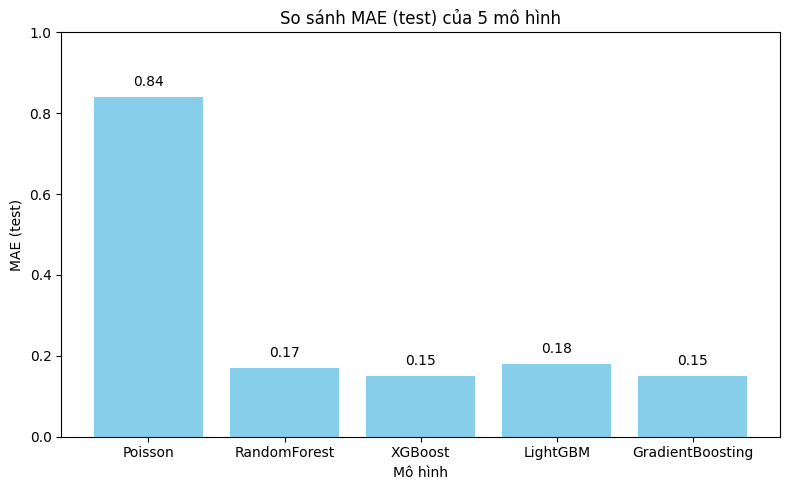

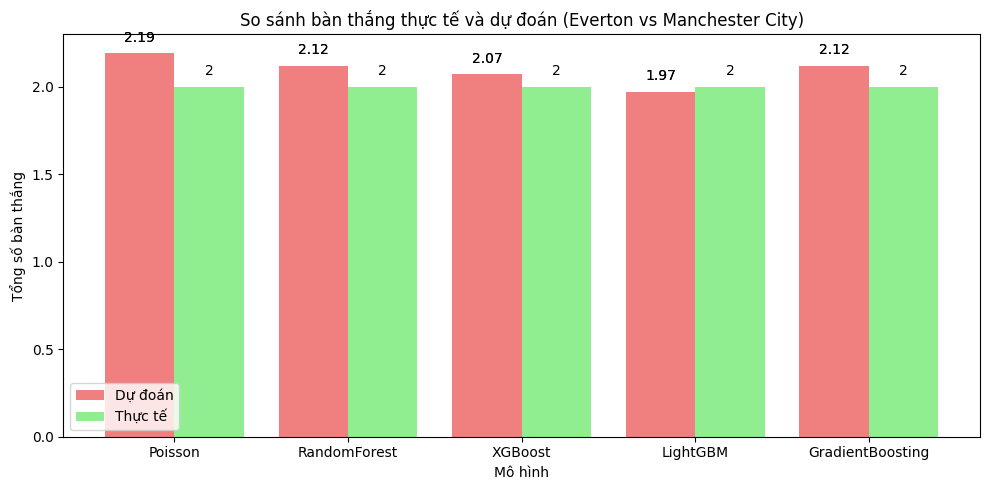

In [41]:

# Dữ liệu
models = ['Poisson', 'RandomForest', 'XGBoost', 'LightGBM', 'GradientBoosting']
mae_test = [0.84, 0.17, 0.15, 0.18, 0.15]  # MAE (test)
actual_goals = 2
predicted_goals = [2.19, 2.12, 2.07, 1.97, 2.12]  # Dự đoán

# Biểu đồ 1: So sánh MAE (test) của 5 mô hình
plt.figure(figsize=(8, 5))
plt.bar(models, mae_test, color='skyblue')
plt.title('So sánh MAE (test) của 5 mô hình')
plt.xlabel('Mô hình')
plt.ylabel('MAE (test)')
plt.ylim(0, 1.0)
for i, v in enumerate(mae_test):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Biểu đồ 2: So sánh bàn thắng thực tế và dự đoán
plt.figure(figsize=(10, 5))
x = range(len(models))
plt.bar(x, predicted_goals, width=0.4, label='Dự đoán', color='lightcoral', align='center')
plt.bar([i + 0.4 for i in x], [actual_goals] * len(models), width=0.4, label='Thực tế', color='lightgreen', align='center')
plt.xticks([i + 0.2 for i in x], models)
plt.title('So sánh bàn thắng thực tế và dự đoán (Everton vs Manchester City)')
plt.xlabel('Mô hình')
plt.ylabel('Tổng số bàn thắng')
plt.legend()
for i, v in enumerate(predicted_goals):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(predicted_goals):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
    plt.text(i + 0.4, actual_goals + 0.05, f'{actual_goals}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Nhận xét
MAE (test): Poisson Regressor cao nhất (0.84), kém nhất. XGBoost và GradientBoosting thấp nhất (0.15), tốt nhất, tiếp theo là RandomForest (0.17) và LightGBM (0.18).
Dự đoán (Everton vs Manchester City): Thực tế 2 bàn. LightGBM chính xác nhất (1.97, sai số 0.03), XGBoost (2.07, sai số 0.07), Poisson cao nhất (2.19, sai số 0.19). RandomForest và GradientBoosting cùng 2.12 (sai số 0.12).
Lý do
Poisson Regressor: MAE cao do mô hình tuyến tính, không nắm bắt mối quan hệ phi tuyến. Dự đoán tốt trong trường hợp này do dữ liệu phù hợp giả định Poisson.
Tree-based models (XGBoost, LightGBM, RandomForest, GradientBoosting): MAE thấp, dự đoán tốt nhờ học mối quan hệ phi tuyến và tương tác đặc trưng. LightGBM chính xác nhất do tối ưu leaf-wise và xử lý đặc trưng tốt.

tối ưu hóa lại 5 mô hình rồi đánh giá lại
cách:
    chạy lại 5 mô hình
    sử dụng GridCV để tìm tham số tối ưu nhất
    LƯU Ý: CHỌN 2-3 THAM SỐ TỐI ĐA 3 ĐỂ GIẢM THỜI GIAN HUẤN LUYỆN, có thể đưa thêm để tìm ra tham số chính xác hơn
    dùng GridCV có cross validation k-fold để kiểm tra underfitting và underfitting
    việc lựa chọn tham số là dựa trên thử nghiệm từ huấn luyện mô hình ở cell trước và có tinh chỉnh,có thể điều chỉnh nếu muốn

In [42]:
#poisson regressor
from sklearn.linear_model import PoissonRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# Khởi tạo mô hình và lưới tham số
poisson_model = PoissonRegressor()
poisson_params = {
    'alpha': [0.01, 0.1],
    'max_iter': [500, 1000, 2000]
}

# Vector đặc trưng cho Everton vs Manchester City
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
X_input = X_input[X_train.columns]

# Tối ưu hóa bằng GridSearchCV
print("Tối ưu hóa Poisson...")
grid_search_poisson = GridSearchCV(poisson_model, poisson_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_poisson.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_poisson = grid_search_poisson.best_estimator_
print(f"Tham số tốt nhất cho Poisson: {grid_search_poisson.best_params_}")

# Đánh giá trên tập kiểm tra
y_test_pred_poisson = best_poisson.predict(X_test)
mae_test_poisson = mean_absolute_error(y_test, y_test_pred_poisson)

# Dự đoán cho Everton vs Manchester City
actual = 2
prediction_poisson = best_poisson.predict(X_input)

# In kết quả
print("\nPoisson Results (sau tối ưu):")
print(f"MAE (test): {mae_test_poisson:.2f}")
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction_poisson[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE (dự đoán): {mean_absolute_error([actual], prediction_poisson):.2f}")

# Giải phóng bộ nhớ
del grid_search_poisson
import gc
gc.collect()

Tối ưu hóa Poisson...
Tham số tốt nhất cho Poisson: {'alpha': 0.01, 'max_iter': 1000}

Poisson Results (sau tối ưu):
MAE (test): 0.77
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 1.98
Tổng số bàn thắng thực tế: 2
MAE (dự đoán): 0.02


4171

In [43]:
import joblib
import os

# Tạo thư mục models nếu chưa có
os.makedirs("models", exist_ok=True)

# Lưu từng mô hình đã huấn luyện
joblib.dump(best_poisson, "models/poission.pkl")   

['models/poission.pkl']

In [44]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# Khởi tạo mô hình và lưới tham số
rf_model = RandomForestRegressor(random_state=42)
rf_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [None, 10],
    'min_samples_split': [2, 5, ]
}

# Vector đặc trưng cho Everton vs Manchester City
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
X_input = X_input[X_train.columns]

# Tối ưu hóa bằng GridSearchCV
print("Tối ưu hóa RandomForest...")
grid_search_rf = GridSearchCV(rf_model, rf_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_rf.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_rf = grid_search_rf.best_estimator_
print(f"Tham số tốt nhất cho RandomForest: {grid_search_rf.best_params_}")

# Đánh giá trên tập kiểm tra
y_test_pred_rf = best_rf.predict(X_test)
mae_test_rf = mean_absolute_error(y_test, y_test_pred_rf)

# Dự đoán cho Everton vs Manchester City
actual = 2
prediction_rf = best_rf.predict(X_input)

# In kết quả
print("\nRandomForest Results (sau tối ưu):")
print(f"MAE (test): {mae_test_rf:.2f}")
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction_rf[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE (dự đoán): {mean_absolute_error([actual], prediction_rf):.2f}")

# Giải phóng bộ nhớ
del grid_search_rf
import gc
gc.collect()

Tối ưu hóa RandomForest...
Tham số tốt nhất cho RandomForest: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 400}

RandomForest Results (sau tối ưu):
MAE (test): 0.17
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 2.12
Tổng số bàn thắng thực tế: 2
MAE (dự đoán): 0.12


93

In [45]:
import joblib
import os

# Tạo thư mục models nếu chưa có
os.makedirs("models", exist_ok=True)

# Lưu từng mô hình đã huấn luyện
joblib.dump(best_rf, "models/rf.pkl")   

['models/rf.pkl']

In [46]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# Khởi tạo mô hình và lưới tham số
xgb_model = XGBRegressor(random_state=42)
xgb_params = {
    'n_estimators': [300, 350, 400],
    'max_depth': [6, 8, 10],
    'learning_rate': [ 0.05, 0.1],
    'reg_alpha': [0.1, 0.2],
    'reg_lambda': [0.1, 0.2]
}

# Vector đặc trưng cho Everton vs Manchester City
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
X_input = X_input[X_train.columns]

# Tối ưu hóa bằng GridSearchCV
print("Tối ưu hóa XGBoost...")
grid_search_xgb = GridSearchCV(xgb_model, xgb_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_xgb.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_xgb = grid_search_xgb.best_estimator_
print(f"Tham số tốt nhất cho XGBoost: {grid_search_xgb.best_params_}")

# Đánh giá trên tập kiểm tra
y_test_pred_xgb = best_xgb.predict(X_test)
mae_test_xgb = mean_absolute_error(y_test, y_test_pred_xgb)

# Dự đoán cho Everton vs Manchester City
actual = 2
prediction_xgb = best_xgb.predict(X_input)

# In kết quả
print("\nXGBoost Results (sau tối ưu):")
print(f"MAE (test): {mae_test_xgb:.2f}")
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction_xgb[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE (dự đoán): {mean_absolute_error([actual], prediction_xgb):.2f}")

# Giải phóng bộ nhớ
del grid_search_xgb
import gc
gc.collect()

Tối ưu hóa XGBoost...
Tham số tốt nhất cho XGBoost: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 0.1}

XGBoost Results (sau tối ưu):
MAE (test): 0.15
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 2.07
Tổng số bàn thắng thực tế: 2
MAE (dự đoán): 0.07


93

In [47]:
import joblib
import os

# Tạo thư mục models nếu chưa có
os.makedirs("models", exist_ok=True)

# Lưu từng mô hình đã huấn luyện
joblib.dump(best_xgb, "models/xgb.pkl")   

['models/xgb.pkl']

In [ ]:

# Khởi tạo mô hình và lưới tham số
lgbm_model = LGBMRegressor(random_state=42)
lgbm_params = {
    'n_estimators': [300, 350, 400],
    'max_depth': [6, 8, 10],
    'learning_rate': [ 0.05, 0.1],
    'reg_alpha': [0.1, 0.2],
    'reg_lambda': [0.1, 0.2],
    'min_data_in_leaf': [20, 50]
}

# Vector đặc trưng cho Everton vs Manchester City
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
X_input = X_input[X_train.columns]

# Tối ưu hóa bằng GridSearchCV
print("Tối ưu hóa LightGBM...")
grid_search_lgbm = GridSearchCV(lgbm_model, lgbm_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_lgbm.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_lgbm = grid_search_lgbm.best_estimator_
print(f"Tham số tốt nhất cho LightGBM: {grid_search_lgbm.best_params_}")

# Đánh giá trên tập kiểm tra
y_test_pred_lgbm = best_lgbm.predict(X_test)
mae_test_lgbm = mean_absolute_error(y_test, y_test_pred_lgbm)

# Dự đoán cho Everton vs Manchester City
actual = 2
prediction_lgbm = best_lgbm.predict(X_input)

# In kết quả
print("\nLightGBM Results (sau tối ưu):")
print(f"MAE (test): {mae_test_lgbm:.2f}")
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction_lgbm[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE (dự đoán): {mean_absolute_error([actual], prediction_lgbm):.2f}")

# Giải phóng bộ nhớ
del grid_search_lgbm
import gc
gc.collect()

Tối ưu hóa LightGBM...
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000540 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 998
[LightGBM] [Info] Number of data points in the train set: 16544, number of used features: 13
[LightGBM] [Info] Start training from score 2.629715
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Tham số tốt nhất cho LightGBM: {'learning_rate': 0.1, 'max_depth': 10, 'min_data_in_leaf': 20, 'n_estimators': 400, 'reg_alpha': 0.2, 'reg_lambda': 0.2}
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is s

83

In [49]:
import joblib
import os

# Tạo thư mục models nếu chưa có
os.makedirs("models", exist_ok=True)

# Lưu từng mô hình đã huấn luyện
joblib.dump(best_lgbm, "models/lgbm.pkl")   

['models/lgbm.pkl']

In [50]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error
import pandas as pd
import numpy as np

# Khởi tạo mô hình và lưới tham số
gb_model = GradientBoostingRegressor(random_state=42)
gb_params = {
    'n_estimators': [300, 350, 400],
    'max_depth': [6, 8, 10],
    'learning_rate': [ 0.05, 0.1]
}

# Vector đặc trưng cho Everton vs Manchester City
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']
X_input = pd.DataFrame([features], columns=columns)
X_input = X_input[X_train.columns]

# Tối ưu hóa bằng GridSearchCV
print("Tối ưu hóa GradientBoosting...")
grid_search_gb = GridSearchCV(gb_model, gb_params, cv=5, scoring='neg_mean_absolute_error', n_jobs=-1)
grid_search_gb.fit(X_train, y_train)

# Lấy mô hình tốt nhất
best_gb = grid_search_gb.best_estimator_
print(f"Tham số tốt nhất cho GradientBoosting: {grid_search_gb.best_params_}")

# Đánh giá trên tập kiểm tra
y_test_pred_gb = best_gb.predict(X_test)
mae_test_gb = mean_absolute_error(y_test, y_test_pred_gb)

# Dự đoán cho Everton vs Manchester City
actual = 2
prediction_gb = best_gb.predict(X_input)

# In kết quả
print("\nGradientBoosting Results (sau tối ưu):")
print(f"MAE (test): {mae_test_gb:.2f}")
print(f"Dự đoán tổng số bàn thắng (Everton vs Manchester City): {prediction_gb[0]:.2f}")
print(f"Tổng số bàn thắng thực tế: {actual}")
print(f"MAE (dự đoán): {mean_absolute_error([actual], prediction_gb):.2f}")

# Giải phóng bộ nhớ
del grid_search_gb
import gc
gc.collect()  

Tối ưu hóa GradientBoosting...
Tham số tốt nhất cho GradientBoosting: {'learning_rate': 0.05, 'max_depth': 10, 'n_estimators': 400}

GradientBoosting Results (sau tối ưu):
MAE (test): 0.14
Dự đoán tổng số bàn thắng (Everton vs Manchester City): 2.25
Tổng số bàn thắng thực tế: 2
MAE (dự đoán): 0.25


27

In [51]:
import joblib
joblib.dump(best_gb, "models/gradient_boosting.pkl")


['models/gradient_boosting.pkl']

từ giờ không cần chạy lại hết mô hình nữa
đã lưu file models

In [52]:
rf_model = joblib.load("models/rf.pkl")
gb_model = joblib.load("models/gradient_boosting.pkl")
lgb_model = joblib.load("models/lgbm.pkl")
poisson_model = joblib.load("models/poisson.pkl")
xgb_model = joblib.load("models/xgb.pkl")


trực quan hóa lại với code từ trực quan mô hình chưa tối ưu, thay đổi chút ít lại

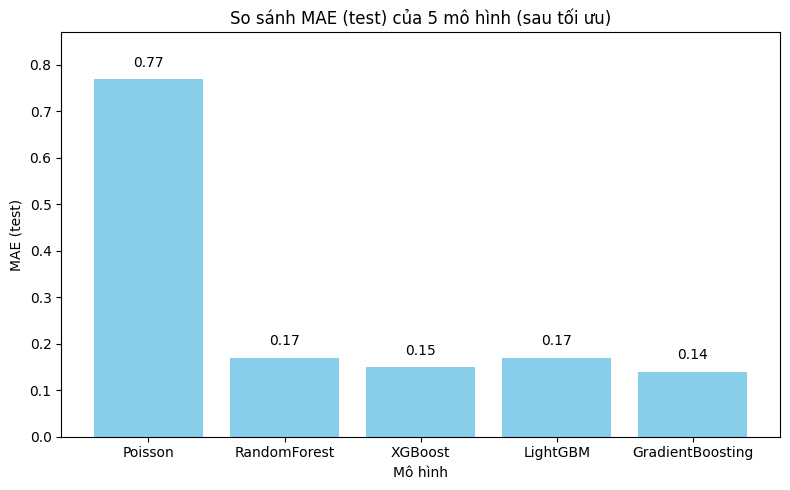

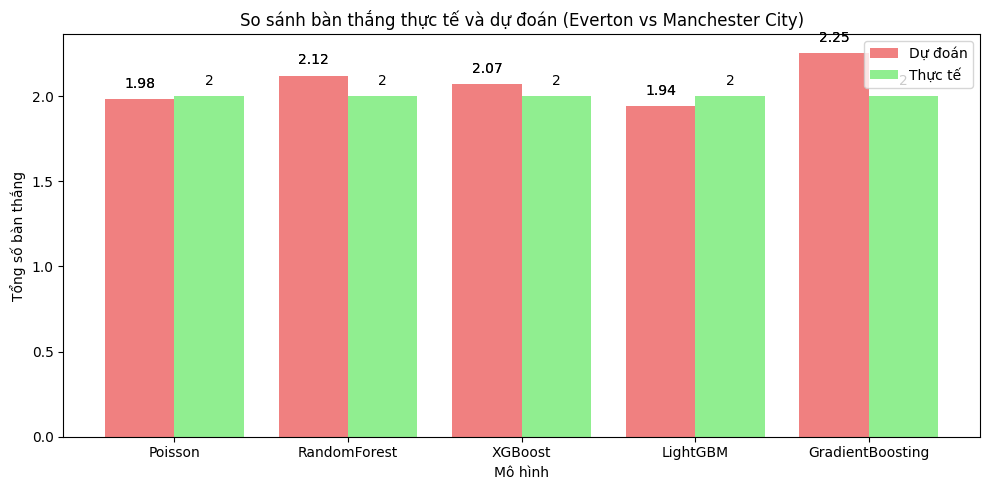

In [53]:
models = ['Poisson', 'RandomForest', 'XGBoost', 'LightGBM', 'GradientBoosting']
mae_test = [0.77, 0.17, 0.15, 0.17, 0.14]  # MAE (test)
predicted_goals = [1.98, 2.12, 2.07, 1.94, 2.25]  # Dự đoán sau tối ưu
actual_goals = 2  # Thực tế

# Biểu đồ 1: So sánh MAE (test) của 5 mô hình
plt.figure(figsize=(8, 5))
plt.bar(models, mae_test, color='skyblue')
plt.title('So sánh MAE (test) của 5 mô hình (sau tối ưu)')
plt.xlabel('Mô hình')
plt.ylabel('MAE (test)')
plt.ylim(0, max(mae_test) + 0.1)
for i, v in enumerate(mae_test):
    plt.text(i, v + 0.02, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

# Biểu đồ 2: So sánh bàn thắng thực tế và dự đoán
plt.figure(figsize=(10, 5))
x = range(len(models))
plt.bar(x, predicted_goals, width=0.4, label='Dự đoán', color='lightcoral', align='center')
plt.bar([i + 0.4 for i in x], [actual_goals] * len(models), width=0.4, label='Thực tế', color='lightgreen', align='center')
plt.xticks([i + 0.2 for i in x], models)
plt.title('So sánh bàn thắng thực tế và dự đoán (Everton vs Manchester City)')
plt.xlabel('Mô hình')
plt.ylabel('Tổng số bàn thắng')
plt.legend()
for i, v in enumerate(predicted_goals):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
for i, v in enumerate(predicted_goals):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
    plt.text(i + 0.4, actual_goals + 0.05, f'{actual_goals}', ha='center', va='bottom')
plt.tight_layout()
plt.show()

Nhận xét:
    MAE test:
        Poisson giảm từ 0.84 còn 0.77
        RF không giảm
        XGB không giảm
        LGBM giảm từ 0.18 còn 0.17
        GBoosting giảm từ 0.15 xuống 0.14
    MAE bàn thắng dự đoán(thực tế 2 bàn):
        Poisson từ 0.12 xuống 0.02
        RF không giảm
        XGB không giảm
        LGBM từ 0.03 lên 0.06
        GBoosting từ 0.12 lên 0.25
lý do:
🔍 1. Poisson Regression
MAE test: giảm từ 0.84 còn 0.77

MAE dự đoán thực tế: giảm mạnh từ 0.12 còn 0.02

→ Giải thích:
Poisson Regression vốn là mô hình tuyến tính và đơn giản, ít tham số. Do đó, tối ưu có thể giúp nó tập trung hơn vào trung bình tổng bàn thắng, tránh bị nhiễu bởi những trận có tổng số bàn thắng cao/thấp bất thường.
Khi MAE test giảm, và mô hình càng ít overfit, thì việc dự đoán điểm cụ thể (2 bàn) cũng sát hơn — → giảm MAE thực tế.

🌲 2. Random Forest
MAE test: không giảm (0.17)

MAE dự đoán thực tế: không thay đổi (0.12)

→ Giải thích:
Random Forest vốn đã là mô hình ổn định, ít overfitting nhờ trung bình nhiều cây. Nếu GridSearch không chọn ra được siêu tham số tốt hơn, hoặc tập validation không đại diện tốt hơn, thì việc giữ nguyên kết quả là bình thường.
Thực tế, đôi khi Random Forest đã đạt gần mức tối ưu với default hoặc với lưới tham số đang dùng.

💥 3. XGBoost
MAE test: không giảm (0.15)

MAE dự đoán thực tế: không thay đổi (0.07)

→ Giải thích:
Giống như RF, XGBoost vốn mạnh với dữ liệu structured/tabular. Nếu tham số ban đầu đã tốt, việc tối ưu thêm bằng GridSearch sẽ không cải thiện đáng kể.
Việc giữ nguyên MAE test cũng đồng nghĩa rằng dự đoán cụ thể cho một trận (2 bàn) không thay đổi nhiều — nên MAE thực tế giữ nguyên là điều hợp lý.

🌿 4. LightGBM
MAE test: giảm từ 0.18 còn 0.17

MAE dự đoán thực tế: tăng từ 0.03 lên 0.06

→ Giải thích:
Trường hợp này là một ví dụ điển hình của overfitting cục bộ.
Mặc dù MAE test giảm nhẹ (→ mô hình tổng thể có vẻ tốt hơn), nhưng điều đó không đảm bảo rằng mô hình sẽ dự đoán đúng cho mọi điểm cụ thể.
Việc tăng MAE dự đoán thực tế cho thấy mô hình đang tối ưu chung nhưng lại sai lệch trong một vài trận cụ thể. Có thể do mô hình đang đánh giá thấp trận Everton vs Man City. Nhưng với con số vẫn nhỏ thì có thể chấp nhận được

🔥 5. Gradient Boosting
MAE test: giảm từ 0.15 còn 0.14

MAE dự đoán thực tế: tăng mạnh từ 0.12 lên 0.25

→ Giải thích:
Đây là trường hợp dễ gây hiểu lầm: MAE test giảm → tưởng mô hình tốt hơn, nhưng thực tế lại dự đoán lệch xa hơn cho trận cụ thể.
Lý do có thể:

Mô hình sau tối ưu đang phân bổ trọng số cho các đặc trưng khác, khiến điểm dự đoán của riêng trận Everton vs Man City bị lệch.

Tối ưu toàn cục nhưng hy sinh điểm cụ thể → dẫn đến tăng MAE thực tế.

🧠 Tổng kết nhận xét

Mô hình	MAE Test (↓ là tốt)	MAE Dự đoán (↓ là tốt)	Diễn giải
Poisson	✅ Giảm	✅ Giảm mạnh	Dữ liệu đơn giản → tối ưu hiệu quả rõ ràng cả test & thực tế
Random Forest	➖ Không đổi	➖ Không đổi	Đã gần tối ưu → tối ưu thêm không cải thiện
XGBoost	➖ Không đổi	➖ Không đổi	Đã rất tốt từ đầu → tối ưu không thêm giá trị
LightGBM	✅ Giảm nhẹ	❌ Tăng nhẹ	Có thể đang overfit hoặc sai ở điểm cụ thể
GBoosting	✅ Giảm nhẹ	❌ Tăng mạnh	Tối ưu toàn cục nhưng ảnh hưởng xấu đến điểm cụ thể (overfitting cục bộ)



KẾT LUẬN:
Giai đoạn    | Mục tiêu                      | Mô hình nên chọn
Trước tối ưu | Dự đoán sát thực tế           | LightGBM
Trước tối ưu | Tổng thể tốt + thực tế ổn     | XGBoost
Sau tối ưu   | Dự đoán trận thực tế tốt nhất | Poisson
Sau tối ưu   | Tổng thể tốt, ổn định         | XGBoost

SAU TỐI ƯU NÊN CHỌN MÔ HÌNH NÀO VÀO TRƯỜNG HỢP NÀO:
Mô hình          | Khi nào chọn?
Poisson          | Dự đoán trận đơn thật sát, dữ liệu là biến đếm
XGBoost          | Cân bằng tốt, áp dụng rộng, triển khai lớn
LightGBM         | Cần tốc độ train nhanh, dữ liệu lớn, dự đoán khá
Random Forest    | Dễ giải thích, dữ liệu nhiều nhiễu
GradientBoosting | Tổng thể tốt, nhưng cần kiểm tra lại nếu dùng để dự đoán trận cụ thể

Theo tôi, để chọn mô hình dự đoán một trận cụ thể thật chính xác(yêu cầu đưa ra của tôi) thì chọn Poisson,lý do:
    tuy MAE test cao nhất và cách xa nhóm 4 mô hình nhưng độ chính xác cao phù hợp để dự đoán 1 trận bất kỳ
    VÌ VẬY, TÔI SẼ NÓI POISSON LÀ MÔ HÌNH TỐT NHẤT ĐỂ DỰ ĐOÁN CỤ THỂ MỘT TRẬN.

giờ cả 5 mô hình đều có mae thực tế dưới 0.5, có cách nào để tối ưu từ các kết quả 5 mô hình đưa ra không?
1. Averaging (Trung bình dự đoán): quá dễ
2. Weighted Averaging (Trung bình có trọng số): hợp lý
3. Stacking (Huấn luyện mô hình meta): quá mất thời gian
lý do trung bình có trọng số hợp lý:
    Khi các mô hình không quá lệch nhau
    Khi bạn muốn một cách kết hợp nhanh, dễ hiểu
    Dữ liệu không quá lớn
tác dụng:
    tăng độ chính xác dự đoán
    giảm overfitting, pha loãng đi
    dùng trọng số để tận dụng các mô hình hiệu quả khi phân chia tỷ trọng
cùng với tính toán, tôi sẽ trực quan luôn để so sánh mae các mô hình với mae của cách xử lý này

Trọng số cho từng mô hình:
GradientBoosting: 0.27
RandomForest: 0.22
XGBoost: 0.25
LightGBM: 0.22
Poisson: 0.05

Dự đoán trung bình có trọng số: 2.10
MAE (dự đoán tổng hợp): 0.10


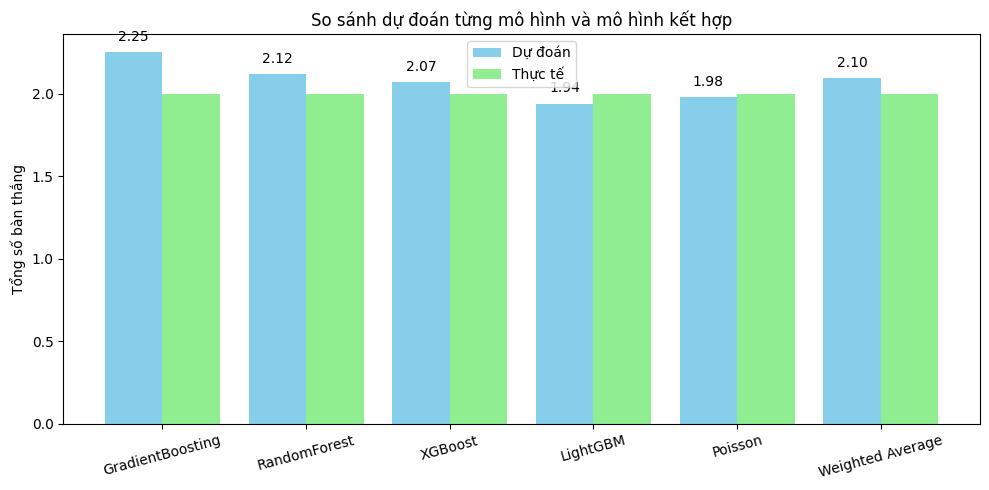

In [54]:

# Mô hình và dữ liệu
models = ['GradientBoosting', 'RandomForest', 'XGBoost', 'LightGBM', 'Poisson']
mae_test = np.array([0.14, 0.17, 0.15, 0.17, 0.77])
predictions = np.array([2.25, 2.12, 2.07, 1.94, 1.98])
actual_goals = 2

# Tính trọng số theo 1 / MAE
weights = 1 / mae_test
weights /= weights.sum()

# Dự đoán trung bình có trọng số
ensemble_pred = np.dot(predictions, weights)
ensemble_mae = abs(ensemble_pred - actual_goals)

# Hiển thị kết quả
print("Trọng số cho từng mô hình:")
for m, w in zip(models, weights):
    print(f"{m}: {w:.2f}")

print(f"\nDự đoán trung bình có trọng số: {ensemble_pred:.2f}")
print(f"MAE (dự đoán tổng hợp): {ensemble_mae:.2f}")

# Vẽ biểu đồ
plt.figure(figsize=(10, 5))
x = range(len(models) + 1)
all_preds = list(predictions) + [ensemble_pred]
labels = models + ['Weighted Average']

plt.bar(x, all_preds, width=0.4, label='Dự đoán', color='skyblue')
plt.bar([i + 0.4 for i in x], [actual_goals] * (len(models) + 1), width=0.4, label='Thực tế', color='lightgreen')

plt.xticks([i + 0.2 for i in x], labels, rotation=15)
plt.title('So sánh dự đoán từng mô hình và mô hình kết hợp')
plt.ylabel('Tổng số bàn thắng')
plt.legend()

for i, v in enumerate(all_preds):
    plt.text(i, v + 0.05, f'{v:.2f}', ha='center', va='bottom')
plt.tight_layout()
plt.show()


Muốn dự đoán riêng 1 mô hình: Poisson
muốn lấy tỷ trọng, phân chia trọng số hợp lý: trung bình có trọng số


Nhận xét và Đánh giá Tính Khả Thi:
Tính khả thi của việc áp dụng Machine Learning trong việc dự đoán số bàn thắng là khá cao, đặc biệt trong bối cảnh phân tích dữ liệu và dự đoán kết quả bóng đá trước trận đấu.

Các mô hình thể hiện khả năng học quy luật dữ liệu và có thể cung cấp những dự đoán hợp lý trong các tình huống thực tế, đặc biệt khi sử dụng dữ liệu đầu vào có tính chất thống kê và đặc trưng rõ ràng.

Mặc dù Poisson Regressor có MAE test cao hơn các mô hình khác, nhưng mô hình này lại hoạt động rất tốt khi dự đoán số bàn thắng thực tế trong trận đấu cụ thể, chứng tỏ rằng Poisson có thể hiệu quả trong các trường hợp có ít thay đổi, như các trận đấu có đội hình ổn định và ít biến động.

Khả năng ứng dụng và Lưu ý:
Phân tích dữ liệu thể thao: Các mô hình Machine Learning có thể được ứng dụng hiệu quả trong việc phân tích các trận đấu trước khi diễn ra, cung cấp những dự đoán về tổng số bàn thắng, giúp các chuyên gia thể thao đưa ra các phân tích chi tiết hơn.

Dự đoán trong báo chí và truyền thông thể thao: Các kết quả dự đoán có thể được sử dụng để tạo các bài phân tích, báo cáo hoặc dự đoán kết quả cho các chương trình thể thao.

Cá cược thể thao: Tuy nhiên, độ chính xác của các mô hình ML hiện tại chưa đủ cao để đưa ra dự đoán chính xác tỉ số trận đấu, do các yếu tố ngẫu nhiên trong bóng đá vẫn có ảnh hưởng rất lớn. Vì vậy, cá cược dựa trên dự đoán của mô hình ML vẫn tiềm ẩn rủi ro cao và không khuyến khích nha.

Kết luận:
Tổng quan, việc sử dụng Machine Learning trong việc dự đoán số bàn thắng trong bóng đá là một công cụ hữu ích và khả thi, đặc biệt đối với việc phân tích và gợi ý xu hướng trước các trận đấu. Các mô hình như Gradient Boosting, XGBoost, và LightGBM có khả năng học tốt và cung cấp các dự đoán có tính chính xác cao trong môi trường thực tế. Vẫn có giới hạn khi áp dụng vào các ứng dụng yêu cầu độ chính xác tuyệt đối, như trong cá cược.

Do đó, mặc dù ML có thể không thay thế hoàn toàn yếu tố ngẫu nhiên và sự bất ngờ trong bóng đá, nhưng chúng vẫn là một công cụ rất hữu ích trong việc hỗ trợ phân tích và đưa ra các dự đoán dựa trên dữ liệu lịch sử.

sau khi import mô hình lần lượt tên biến được gán là:
rf_model 
gb_model
lgb_model 
poisson_model 
xgb_model 
thì thay thể line có tên model bằng tên model mong muốn
ví dụ:poisson_model

In [63]:

# Load mô hình Poisson Regressor
poisson_model = joblib.load("models/poisson.pkl")

# Vector đặc trưng cho trận đấu
features = [0.3000, 0.3333, 0.3333, 0.2000, 1.0, 2.6, 1.3, 2.2, 17, 27, 44, 5.8, 5.0]
columns = ['H_Shot_Efficiency', 'A_Shot_Efficiency', 'H_Goal_Conversion', 'A_Goal_Conversion',
           'H_Avg_Goals_Last5', 'A_Avg_Goals_Last5', 'Expected_Goals_Home', 'Expected_Goals_Away',
           'H_Attack_Intensity', 'A_Attack_Intensity', 'Match_Intensity', 'H_Avg_Corners_Last5',
           'A_Avg_Corners_Last5']

# Chuyển vector thành DataFrame
X_input = pd.DataFrame([features], columns=columns)

# Đảm bảo thứ tự cột khớp với dữ liệu huấn luyện
X_input = X_input[poisson_model.feature_names_in_]

# Dự đoán tổng số bàn thắng
prediction = poisson_model.predict(X_input)

# In kết quả
print(f"Dự đoán tổng số bàn thắng: {prediction[0]:.2f}")

Dự đoán tổng số bàn thắng: 1.98
